# Team BNP: Feature Selection, Classifier Training, and Walk-Forward Optimization

Renjie Pan (renjie.pan@nyu.edu)

Tianyu Zhang (tianyuzhang@nyu.edu)

Liang Zou (liazou@nyu.edu)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import random
from collections import Counter
import re
import math
import pickle
# import one_hot_encoder
# import utils
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import precision_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
merge_1month = pd.read_csv('merge_1month.csv').reset_index()
merge_3month = pd.read_csv('merge_3month.csv').reset_index()

Date_1month = merge_1month['Date']
Date_3month = merge_3month['Date']

# merge_1month = merge_1month.iloc[1:,:].reset_index()
# merge_3month = merge_3month.iloc[3:,:].reset_index()

merge_1month = merge_1month.drop(columns=['index','Date'])
merge_3month = merge_3month.drop(columns=['index','Date'])

In [3]:
def cont_2_binary(x):
    """
    Transform continuous variable to binary
    @param x: float or NaN
    @return: integer or NaN
    """
    if np.isnan(x):
        # if x is NaN, return NaN
        return np.nan
    return int(x > 0)

In [4]:
merge_1month_X = merge_1month[merge_1month.columns[:-15]]
merge_1month_X = merge_1month_X.replace([np.inf, -np.inf], np.nan)
merge_1month_Y = merge_1month[merge_1month.columns[-15:]].applymap(lambda x: cont_2_binary(x))

## Feature Selection: Left Co-moment Absolute Score

In [5]:
def abs_left_co_moment(X, y, dim, isCentralized = False):
    """
    This function calculates the n-order abs left co-moments
    
    inputs:
    X || Dataframe, includes colunms for to calculate the co-moment with y one-by-one
    y || Dataframe , includes one colunms to calculate the co-moment with multiple x in the X
    isCentralized || Boolean, if "True", use the centralized version of the X and y
                                if "False", use the original inputs to calculate
                                
    Output:
    result || Series, includes the co-moment for different x in X
    """
    cols = X.columns
    
    if isCentralized:
        X = X - X.mean()
        y = y - y.mean()
    
    vx = np.abs(X.values.T)
    vy = np.abs(y.values.T)
    result = []
    
    for i in range(len(vx)):
        result.append(np.mean(np.power(vx[i],(dim-1))*vy) / 
                      np.power((np.power(np.mean(np.power(vx[i],dim)),dim-1)*np.mean(np.power(vy,dim))),1/dim))
    
    result = pd.Series(result, index =cols) 
    return result

def get_score(X, y, isCentralized = False):
    """
    This function calculates the score: 1/2 absCorr + 1/6 absCosk + 1/24 absCoku
    inputs:
    X || Dataframe, includes colunms for to calculate the co-moment with y one-by-one
    y || Dataframe , includes one colunms to calculate the co-moment with multiple x in the X
    isCentralized || Boolean, if "True", use the centralized version of the X and y
                                if "False", use the original inputs to calculate
                                
    Output:
    score || Series, includes the score for different x in X
    """
    
    abs_corr = abs_left_co_moment(X, y, 2, isCentralized)
    abs_cosk = abs_left_co_moment(X, y, 3, isCentralized)
    abs_coku = abs_left_co_moment(X, y, 4, isCentralized)
    
    score = 0.5*abs_corr + 1/6*abs_cosk + 1/24*abs_coku
    return score

def gen_MC_signals(y,dist):
    """
    This function generates len(y) realizations from a given distribution
    
    inputs:
    y || dataframe, contains one list of target variables
    dist || accept any API from: https://docs.scipy.org/doc/numpy-1.14.0/reference/routines.random.html#distributions
    
    output:
    dataframe || contains one column which is the MC signals
    e.g.: gen_MC_signals(y,np.random.standard_normal)
    """
    random_dist = dist(size=len(y))
    return pd.Series(random_dist).to_frame()

def filter_by_comoment(X, y, w = 1, isCentralized = False, n_sim = 1000, max_feature = 10):
    """
    This function first calculates the MC bar of a given target variable y and filter out features by the MCbar
    example: filter_by_comoment(merge_1month_X_df1, y,1.2)[0]
    
    inputs:
    X || Dataframe, includes colunms for to calculate the co-moment with y one-by-one
    y || Dataframe , includes one colunms to calculate the co-moment with multiple x in the X
    isCentralized || Boolean, if "True", use the centralized version of the X and y
                                if "False", use the original inputs to calculate
    w || float, factor of standard deviations away from the mean
    n_sim || integer, number of simulations
    max_feature || integer, maximum number of features
                                
    outputs:
    # list || a list contains the name of the features after filtered
    list || a pd.Series that contains the scores of the above festures
    """
    score = get_score(X,y,isCentralized = False)
    MC_bars = []
    
    for i in range(n_sim):
        MC_bars.append(get_score(gen_MC_signals(y,np.random.standard_normal),y).values[0])
        
    MC_bar = np.array(MC_bars).mean()
        
    best_features = score[score.between(w * MC_bar, 1, inclusive=False)]
    best_features = best_features.sort_values(ascending=False)
    return best_features[:max_feature]

In [6]:
def train_test_feature_selection(X_train, Y_train, X_test, Y_test, feature_selection_method = filter_by_comoment):
    """
    Perform feature selection using training set and choose the same features in test
    @X_train: Pandas DataFrame
    @Y_train: Pandas Series
    @X_test: Pandas DataFrame
    @Y_test: Pandas Series
    @feature_selection_method: any feature selection methods which accept (X_train, Y_train) and return Pandas Series
    @return: X_train (selected features), Y_train, X_test (selected features), Y_test, 
    """
    
    feature_score = feature_selection_method(X_train, Y_train)
    return X_train[feature_score.index], Y_train, X_test[feature_score.index], Y_test

In [8]:
# train_test_feature_selection(sample_X_train, sample_Y_train, sample_X_test, sample_Y_test)
filter_by_comoment(merge_1month_X.iloc[:100,:].dropna(axis=1),merge_1month_Y.iloc[:100,1])

EPUCJNMP Index 6 mo avg                                   0.557296
FRCCCARS Index                                            0.557275
FRCCCARS Index 2 mo avg                                   0.556693
FRCCCARS Index 6 mo avg                                   0.555504
FRCCCARS Index 3 mo avg                                   0.555361
ITPSSAVC Index 12 mo avg                                  0.555147
EUESIT Index 12 mo avg                                    0.554624
CONSEXFB Index 12 mo avg                                  0.554559
Number of States with positive leading index 12 mo avg    0.554406
ITPSSAVC Index 6 mo avg                                   0.553910
dtype: float64

## Classifier Training: Models Pool

In [7]:
pool_classifier = [
    XGBClassifier(learning_rate=0.03, n_estimators=300, n_jobs=-1, silent=False),
    #MSCI Japan, Russell 2000, US IG Corps, US Mortgages
    #XGBClassifier(learning_rate=0.03, n_estimators=500, n_jobs=-1, silent=False),
    XGBClassifier(learning_rate=0.03, n_estimators=1000, n_jobs=-1, silent=False),# US HY Corp, 
    GradientBoostingClassifier(loss='deviance',learning_rate=0.05,n_estimators=300),
    #MSCI World, S&P GSCI Total Return Index
    #GradientBoostingClassifier(loss='exponential',learning_rate=0.05,n_estimators=300),
    GradientBoostingClassifier(loss='deviance',learning_rate=0.05,n_estimators=500),#MSCI EM, UST 7-10yr
    GradientBoostingClassifier(loss='exponential',learning_rate=0.05,n_estimators=500),#S&P GSCI Total Return Index
    GradientBoostingClassifier(loss='deviance',learning_rate=0.05,n_estimators=1000),#Crude Oil Total Return
    #GradientBoostingClassifier(loss='deviance',learning_rate=0.1,n_estimators=500),
    GradientBoostingClassifier(loss='exponential',learning_rate=0.03,n_estimators=500),#CRB Metals
    SVC(kernel='rbf',probability=True,gamma='auto'),#German 7-10yr
    #SVC(kernel='rbf',probability=True,gamma=1),
    #SVC(C=.001,kernel='rbf',probability=True,gamma=1),
    #SVC(C=.01,kernel='rbf',probability=True,gamma=1),
    #SVC(C=.1,kernel='rbf',probability=True,gamma=1),
    #SVC(C=10,kernel='rbf',probability=True,gamma=1),
    #Cs = [0.001, 0.01, 0.1, 1, 10]
    #gammas = [0.001, 0.01, 0.1, 1]
    SVC(kernel='sigmoid',probability=True,gamma='auto'),#Gold Price
    RandomForestClassifier(n_estimators=300),#Eurostoxx 600
    RandomForestClassifier(n_estimators=500),#SPX 500 Price Return
    #RandomForestClassifier(n_estimators=300,max_depth=10,max_features='sqrt',min_samples_leaf=2),
    #LogisticRegression(C=1, solver='newton-cg'),
    #LogisticRegression(C=0.5, solver='newton-cg')
]

## Classifier Training: Model Selection

In [8]:
def train_test_metric(X_train, Y_train, X_test, Y_test, model, metric):
    """
    Fit model using training set and validate using test set based on certain metric
    @X_train: Pandas DataFrame
    @Y_train: Pandas Series
    @X_test: Pandas DataFrame
    @Y_test: Pandas Series
    @model: any model which contains 'fit' and 'predict' method
    @metric: metric which can compare Y_test and Y_pred
    """
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    return metric(Y_test, Y_pred)

def train_test_model_pool(X_train, Y_train, X_test, Y_test, model_pool, metrics, is_prob):
    """
    Perform model selection based on lists of different metric
    we use accuracy roc_auc_score, average_precision_score
    @X_train: Pandas DataFrame
    @Y_train: Pandas Series
    @X_test: Pandas DataFrame
    @Y_test: Pandas Series
    @model: a list of models which contain 'fit' and 'predict' method
    @metrics: a list of metrics to evaluate model performances
    @is_prob: a list of Booleans which indicate whether it's probability or actual prediction
    @return: list of best classifier, list of best metrics
    """
    best_scores = [-float('inf')] * len(metrics)
    best_models = [None] * len(metrics)
    
    for model in model_pool:
        model.fit(X_train, Y_train)
        Y_pred = model.predict(X_test)
        # Y_pred_prob = model.predict_proba(X_test)[:,1]
        # Y_pred_prob = model.predict_proba(X_test)
        
        for index, metric in enumerate(metrics):
            
            if is_prob[index]:
                Y_pred_result = model.predict_proba(X_test)[:,1]
            else:
                Y_pred_result = Y_pred
            
            metric_score = metric(Y_test, Y_pred_result)
            
            if metric_score > best_scores[index]:
                best_scores[index] = metric_score
                best_models[index] = model
            
    return best_scores, best_models

In [11]:
sample_X = merge_1month_X.iloc[:100,:].dropna(axis=1).copy()
sample_Y = merge_1month_Y.iloc[:100,1].dropna().copy()

sample_X_train = sample_X.iloc[:-20].copy()
sample_Y_train = sample_Y.iloc[:-20].copy()

sample_X_test = sample_X.iloc[-20:].copy()
sample_Y_test = sample_Y.iloc[-20:].copy()

In [12]:
train_test_model_pool(sample_X_train, sample_Y_train, sample_X_test, sample_Y_test, pool_classifier, 
                      [accuracy_score, average_precision_score, roc_auc_score], 
                      [False, False, True])

([0.75, 0.8041666666666667, 0.5733333333333333],
 [XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
                max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
                n_jobs=-1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=False, subsample=1),
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
                max_depth=3, min_child_weight=1, missing=None, n_estimators=300,
                n_jobs=-1, nthread=None, objective='binary:logistic',
                random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                seed=None, silent=False, subsample=1),
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gi

## Backtest: Walk-Forward Optimization

In [9]:
def walk_forward_opt(X_data, Y_data, model_pool, metrics, is_prob, metric_col_name,
                     window_size = 10 * 12, step_size = 18, backtest_size = 2 * 12):
    """
    Use walk-forward optimization to choose different models in different time stamps
    @X_train: Pandas DataFrame
    @Y_train: Pandas Series
    @X_test: Pandas DataFrame
    @Y_test: Pandas Series
    @model: a list of models which contain 'fit' and 'predict' method
    @metrics: a list of metrics to evaluate model performances
    @is_prob: a list of Booleans which indicate whether it's probability or actual prediction
    @metric_col_name: a list of metrics column names
    @window_size: integer (number of sample to include within each window)
    @step_size: integer (size for walk-forward)
    @backtest_size: integer (sample size for test set should be at least step size)
    @return: Pandas DataFrame (summary table)
    """
    
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    X_data.columns = [regex.sub("_", col) if any(x in str(col) \
                for x in set(('[', ']', '<'))) else col for col in X_data.columns.values]

    cur_index = 0
    result_summary = []
    features_training = []
    
    while cur_index + window_size < len(X_data):
        
        # Choose features without missing values
        sample_X = X_data.iloc[cur_index:cur_index+window_size,:].dropna(axis=1).copy()
        sample_Y = Y_data[cur_index:cur_index+window_size].dropna().copy()
        
        if len(sample_X) != len(sample_Y) or len(sample_X) <= backtest_size or len(sample_Y) <= backtest_size:
                        
            # if len(sample_X) <= backtest_size or len(sample_Y) <= backtest_size:
            if sample_Y.isna().sum() == len(sample_Y):
                cur_index += step_size
                result_summary.append([np.nan] * len(metrics))
                continue
            
            # print([len(sample_X), len(sample_Y)])
            # print(sample_X.index)
            # print(sample_Y.index)
            
            # Find common rows that do not contain missing values
            start_index = max(sample_X.index[0], sample_Y.index[0])
            end_index = min(sample_X.index[-1], sample_Y.index[-1])
            
            # print([start_index, end_index])
            
            sample_X = sample_X.iloc[start_index:end_index+1,:].copy()
            sample_Y = sample_Y[start_index:end_index+1].copy()
            
            if len(sample_X) <= backtest_size or len(sample_Y) <= backtest_size:
                cur_index += step_size
                result_summary.append([np.nan] * len(metrics))
                continue
                            
        sample_X_train = sample_X.iloc[:-backtest_size].copy()
        sample_Y_train = sample_Y.iloc[:-backtest_size].copy()

        sample_X_test = sample_X.iloc[-backtest_size:].copy()
        sample_Y_test = sample_Y.iloc[-backtest_size:].copy()
        
        # print([len(sample_X_train), len(sample_Y_train), len(sample_X_test), len(sample_Y_test)])
        # print([sample_X_train.shape, sample_Y_train.shape, sample_X_test.shape, sample_Y_test.shape])
        
        # Feature Selection
        X_train, Y_train, X_test, Y_test = train_test_feature_selection(sample_X_train, sample_Y_train, 
                                                                        sample_X_test, sample_Y_test)
        
        # Model Training with best scores
        best_scores, best_models = train_test_model_pool(X_train.values, Y_train, X_test.values, Y_test, 
                                                         model_pool, metrics, is_prob)
        
        result_summary.append(best_scores + best_models)
        # result_summary.append(best_scores)
        
        # Added selected features during this period
        features_training.append(X_train.columns)
        
        cur_index += step_size
    
    result_summary = pd.DataFrame(result_summary)
    result_summary.columns = metric_col_name + [x + '_Model' for x in metric_col_name]
    
    return result_summary, features_training

In [14]:
walk_forward_opt(merge_1month_X, merge_1month_Y.loc[:,'CRB Metals'], pool_classifier, 
                      [accuracy_score, average_precision_score, roc_auc_score], 
                      [False, True, True], ['Accuracy','Precision','AUC-ROC'])[0]

Accuracy  Precision   AUC-ROC  \
0        NaN        NaN       NaN   
1        NaN        NaN       NaN   
2        NaN        NaN       NaN   
3        NaN        NaN       NaN   
4        NaN        NaN       NaN   
5        NaN        NaN       NaN   
6        NaN        NaN       NaN   
7        NaN        NaN       NaN   
8   0.583333   0.694158  0.678322   
9   0.666667   0.840657  0.652344   
10  0.458333   0.587191  0.614286   
11  0.583333   0.619219  0.618056   
12  0.541667   0.393364  0.500000   
13  0.541667   0.477955  0.500000   
14  0.625000   0.715650  0.684028   

                                       Accuracy_Model  \
0                                                None   
1                                                None   
2                                                None   
3                                                None   
4                                                None   
5                                                None   
6                                                None   
7                                                None   
8   XGBClassifier(base_score=0.5, booster='gbtree'...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  XGBClassifier(base_score=0.5, booster='gbtree'...   
11  XGBClassifier(base_score=0.5, booster='gbtree'...   
12  XGBClassifier(base_score=0.5, booster='gbtree'...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                      Precision_Model  \
0                                                None   
1                                                None   
2                                                None   
3                                                None   
4                                                None   
5                                                None   
6                                                None   
7                                                None   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   ([DecisionTreeRegressor(criterion='friedman_ms...   
10  (DecisionTreeClassifier(class_weight=None, cri...   
11  ([DecisionTreeRegressor(criterion='friedman_ms...   
12  SVC(C=1.0, cache_size=200, class_weight=None, ...   
13  XGBClassifier(base_score=0.5, booster='gbtree'...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                        AUC-ROC_Model  
0                                                None  
1                                                None  
2                                                None  
3                                                None  
4                                                None  
5                                                None  
6                                                None  
7                                                None  
8   SVC(C=1.0, cache_size=200, class_weight=None, ...  
9   (DecisionTreeClassifier(class_weight=None, cri...  
10  (DecisionTreeClassifier(class_weight=None, cri...  
11  SVC(C=1.0, cache_size=200, class_weight=None, ...  
12  SVC(C=1.0, cache_size=200, class_weight=None, ...  
13  SVC(C=1.0, cache_size=200, class_weight=None, ...  
14  ([DecisionTreeRegressor(criterion='friedman_ms...

## One Month Prediction (This takes a long time to run)

In [10]:
def metric_model_feature_table(X_all_data, Y_all_data, model_pool, metrics, is_prob, metric_col_name):
    """
    Generate metric, model and feature table for each asset class
    @param X_all_data: Pandas DataFrame (all features)
    @param Y_all_data: Pandas DataFrame (all labels)
    @param model: a list of models which contain 'fit' and 'predict' method
    @param metrics: a list of metrics to evaluate model performances
    @param is_prob: a list of Booleans which indicate whether it's probability or actual prediction 
    @param metric_col_name: a list of strings (column names of metrics)
    @return: 3 lists of Pandas DataFrames
    """
    metric_table = [dict() for _ in range(len(metrics))]
    model_table = [dict() for _ in range(len(metrics))]
    features_table = dict()

    for asset_class in Y_all_data.columns.values:
        # for each asset class, perform walk-forward optimization
        # print(asset_class)
        summary_table, features_used = walk_forward_opt(X_all_data, Y_all_data.loc[:,asset_class], 
                    model_pool, metrics, is_prob, metric_col_name)
        
        for index, col_name in enumerate(metric_col_name):
            metric_table[index][asset_class] = summary_table[col_name]
            model_table[index][asset_class] = summary_table[col_name + '_Model']
            
        features_table[asset_class] = features_used
    
    # Transform dictionary to pandas dataframe
    for index in range(len(metric_col_name)):
        metric_table[index] = pd.DataFrame(metric_table[index]).round(4)
        model_table[index] = pd.DataFrame(model_table[index])
    
    return metric_table, model_table, features_table

In [11]:
metric_classify_1m, model_classify_1m, features_classify_1m = metric_model_feature_table(
                                 merge_1month_X, merge_1month_Y, pool_classifier, 
                                    [accuracy_score, average_precision_score, roc_auc_score], 
                                        [False, True, True], ['Accuracy','Precision','AUC-ROC'])

## Combine model results

In [20]:
def generate_pred(models, features, X_matrix):
    """
    
    Generate predictions combining all models
    @param models: sklearn models
    @param features: features columns
    @param X_matrix: Pandas DataFrame
    @param weight_fun: a function to combine results from different classifiers 
    weight_fun = lambda x: int(np.mean(x) >= 0.5)
    @return: Pandas Series (model predicted outputs)
    """
    n = len(X_matrix)
    pred_result = dict()
    # print(len(models))
    # print(len(features))
    
    for index, model in enumerate(models):
        # print(X_matrix[features[index]].dropna().values.shape)
        X_test = X_matrix[features[index]].dropna().values
        
        if model == None:
            pred_result[index] = np.array([np.nan] * n)
            continue
        
        if len(X_test) < n:
            # fill missing values with mean
            X_test = X_matrix[features[index]].apply(lambda x: x.fillna(x.mean()),axis=0).values
            
        pred_result[index] = model.predict(X_test)
        # print(pred_result[index].shape)
        # pred_result[index] = np.append(pred_result[index], [np.nan] * (n - len(pred_result[index])))
    
    pred_result_pd = pd.DataFrame(pred_result)
    
    # print([pred_result_pd.shape[0], pred_result_pd.shape[1]] )
    index = list(math.floor(x) for x in np.arange(pred_result_pd.shape[0]) / pred_result_pd.shape[0]
                 * pred_result_pd.shape[1])
    
    # print(index)
    # pred_result_pd['Index'] = pred_result_pd.index
    # pred_result_pd['Total'] = pred_result_pd.apply(func=weight_fun, axis=1)
    return pred_result_pd

In [121]:
from pandas import ExcelWriter

def save_pred_to_excel(model_table, features_table, X_all_data, Y_all_data, title='pred_1month.xlsx'):
    """
    Generate predictions for all asset classes
    @features_table: dictionary (y: list of feature column names)
    @model_table: dictionary (y: list of models)
    @param X_all_data: Pandas DataFrame (all features)
    @param Y_all_data: Pandas DataFrame (all labels)
    """
    with ExcelWriter(title) as writer:
        
        for asset_class in Y_all_data.columns.values:
            models = list(filter(None, model_table[asset_class]))
            asset_pred = generate_pred(models, features_table[asset_class], X_all_data)
            asset_pred.to_excel(writer, sheet_name=asset_class, index=False)
        
        writer.save()

In [41]:
def weighted_avg(dataframe, threshold=0.5):
    """
    Compute the weighted average of time series
    @param dataframe: Pandas DataFrame or numpy array
    @param threshold: float (threshold for classification)
    @return: Pandas Series: (averaged predictions)
    """
    
    def weight_avg_by_row(series):
        """
        Compute weight result
        @param series: Pandas Series
        @return: float (weighted average result)
        """
        weight = np.arange(1, len(series)+1) / 10
        weight_result = np.sum(series * weight) / np.sum(weight)
        return int(weight_result >= threshold)
    
    df_series = dataframe.apply(lambda x: weight_avg_by_row(x), axis=1)
    return df_series

def weight_by_time(dataframe, threshold=0.5):
    """
    Aggregate model result based on time
    @param dataframe: Pandas DataFrame or numpy array
    @param threshold: float (threshold for classification)
    @return: Pandas Series: (averaged predictions)
    """
    n_observation, n_classifier = dataframe.shape
    
    for col in range(n_classifier):
        dataframe.iloc[:(col * n_classifier), col] = np.nan
    
    def weight_avg_dropna(series):
        """
        Compute weight result after dropping nan's
        @param series: Pandas Series
        @return: float (weighted average result)
        """
        series = series.dropna()
        weight = np.arange(1, len(series)+1) / 10
        weight_result = np.sum(series * weight) / np.sum(weight)
        return int(weight_result >= threshold)
    
    df_series = dataframe.apply(lambda x: weight_avg_dropna(x), axis=1)
    return df_series

In [26]:
def generate_pred_all_assets(model_table, features_table, X_all_data, Y_all_data, weight_fun, 
                             Date_index, title='pred_1month.csv'):
    """
    Generate predictions for all asset classes
    @features_table: dictionary (y: list of feature column names)
    @model_table: dictionary (y: list of models)
    @param X_all_data: Pandas DataFrame (all features)
    @param Y_all_data: Pandas DataFrame (all labels)
    @param weight_fun: a function to combine results from different classifiers 
    @return: Pandas DataFrame(predictions of all asset classes)
    """
    
    pred_results = dict()
    
    for asset_class in Y_all_data.columns.values:
        models = list(filter(None, model_table[asset_class]))
        # if None in model_table[asset_class]:
            # models = [x for x in model_table[asset_class] if x is None]
        
        # print([len(models),len(features_table[asset_class])])
        pred_results[asset_class] = weight_fun(generate_pred(models, features_table[asset_class], X_all_data))
                                                  # lambda x: find_time_model(x, n=len(Y_all_data)))
                                                  # lambda x: weighted_avg(x))
    
    # Map 0, 1 to -1, 1
    pred_results_pd = (pd.DataFrame(pred_results) - 0.5) * 2
    pred_results_pd.index = Date_index
    
    # Write CSV
    # pred_results_pd.to_csv(title)
    
    return pred_results_pd

In [18]:
# can replace model_classify_1m[0] (accuracy) with model_classify_1m[1] (precision) or model_classify_1m[2] (auc-roc)
generate_pred_all_assets(model_classify_1m[0], features_classify_1m, 
                         merge_1month_X, merge_1month_Y, weighted_avg, Date_1month)

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
Date                                                                            
1988-01     -1.0                   1.0            1.0        -1.0         1.0   
1988-02     -1.0                   1.0            1.0        -1.0         1.0   
1988-03     -1.0                   1.0            1.0        -1.0         1.0   
1988-04     -1.0                   1.0            1.0        -1.0         1.0   
1988-05     -1.0                   1.0            1.0        -1.0         1.0   
...          ...                   ...            ...         ...         ...   
2019-04      1.0                   1.0            1.0         1.0         1.0   
2019-05      1.0                   1.0            1.0        -1.0         1.0   
2019-06      1.0                   1.0            1.0        -1.0         1.0   
2019-07      1.0                   1.0            1.0        -1.0         1.0   
2019-08     -1.0                   1.0            1.0        -1.0         1.0   

         Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
Date                                                                    
1988-01          -1.0                     1.0         1.0         1.0   
1988-02          -1.0                     1.0         1.0         1.0   
1988-03          -1.0                     1.0         1.0         1.0   
1988-04          -1.0                     1.0         1.0         1.0   
1988-05          -1.0                     1.0         1.0         1.0   
...               ...                     ...         ...         ...   
2019-04          -1.0                     1.0         1.0         1.0   
2019-05          -1.0                     1.0         1.0         1.0   
2019-06          -1.0                     1.0         1.0         1.0   
2019-07          -1.0                     1.0         1.0         1.0   
2019-08          -1.0                     1.0         1.0         1.0   

         S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
Date                                                                           
1988-01                          1.0         1.0            1.0         -1.0   
1988-02                          1.0         1.0            1.0         -1.0   
1988-03                          1.0         1.0            1.0         -1.0   
1988-04                          1.0         1.0            1.0         -1.0   
1988-05                          1.0         1.0            1.0         -1.0   
...                              ...         ...            ...          ...   
2019-04                          1.0         1.0            1.0         -1.0   
2019-05                          1.0         1.0            1.0         -1.0   
2019-06                          1.0         1.0            1.0         -1.0   
2019-07                          1.0         1.0            1.0         -1.0   
2019-08                          1.0         1.0            1.0         -1.0   

         US HY Corp  US Mortgages  
Date                               
1988-01         1.0           1.0  
1988-02        -1.0           1.0  
1988-03        -1.0           1.0  
1988-04        -1.0           1.0  
1988-05        -1.0           1.0  
...             ...           ...  
2019-04         1.0           1.0  
2019-05         1.0           1.0  
2019-06         1.0           1.0  
2019-07         1.0           1.0  
2019-08         1.0           1.0  

[380 rows x 15 columns]

In [15]:
MSCI_result, MSCI_Feature = walk_forward_opt(merge_1month_X, merge_1month_Y.loc[:,'MSCI EM'], 
                    pool_classifier, [accuracy_score, average_precision_score, roc_auc_score], 
                      [False, True, True], ['Accuracy','Precision','AUC-ROC'])

generate_pred(MSCI_result['Accuracy_Model'], MSCI_Feature, merge_1month_X)

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
0     1   0   1   0   1   1   0   1   0   1   0   0   0   1   0
1     1   1   1   0   1   1   0   1   0   1   0   0   0   1   0
2     0   0   1   1   1   1   0   1   0   1   0   0   0   1   0
3     0   0   1   0   1   1   0   1   0   1   0   0   0   1   0
4     1   0   1   0   1   1   0   1   0   1   0   0   0   1   0
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
375   1   0   1   1   1   1   0   1   0   1   0   0   0   1   0
376   1   0   1   0   1   1   0   1   0   1   0   0   0   1   1
377   1   0   1   1   1   1   0   1   0   1   0   0   0   1   1
378   1   0   1   0   1   1   0   1   0   1   0   0   0   1   1
379   1   0   1   0   1   1   0   1   0   1   0   0   0   1   0

[380 rows x 15 columns]

In [43]:
result_MSCI = generate_pred(MSCI_result['Accuracy_Model'], MSCI_Feature, merge_1month_X)
result_MSCI

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
0     1   0   1   0   1   1   0   1   0   1   0   0   0   1   0
1     1   1   1   0   1   1   0   1   0   1   0   0   0   1   0
2     0   0   1   1   1   1   0   1   0   1   0   0   0   1   0
3     0   0   1   0   1   1   0   1   0   1   0   0   0   1   0
4     1   0   1   0   1   1   0   1   0   1   0   0   0   1   0
..   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
375   1   0   1   1   1   1   0   1   0   1   0   0   0   1   0
376   1   0   1   0   1   1   0   1   0   1   0   0   0   1   1
377   1   0   1   1   1   1   0   1   0   1   0   0   0   1   1
378   1   0   1   0   1   1   0   1   0   1   0   0   0   1   1
379   1   0   1   0   1   1   0   1   0   1   0   0   0   1   0

[380 rows x 15 columns]

In [45]:
pred_1m_acc = generate_pred_all_assets(model_classify_1m[0], features_classify_1m, 
                         merge_1month_X, merge_1month_Y, weight_by_time, Date_1month)

In [69]:
np.mean(((merge_1month_Y - 0.5) * 2).fillna(0).values * pred_1m_acc.values == 1, axis=0)

array([0.46842105, 0.61315789, 0.52894737, 0.51842105, 0.54473684,
       0.5       , 0.54736842, 0.32631579, 0.51315789, 0.55789474,
       0.52105263, 0.55263158, 0.56052632, 0.52894737, 0.52105263])

In [78]:
def summary_result_by_asset(true_df, pred_df, metric):
    """
    Summarize result by asset
    @param true_df: Pandas DataFrame
    @param pred_df: Pandas DataFrame
    @param metric: sklearn metric function
    @return: Pandas Series (metric)
    """
    result_metric = []
    assets = pred_df.columns
    new_true_df = ((true_df - 0.5) * 2).fillna(0)
    
    for col in range(new_true_df.shape[1]):
        result_metric.append(metric(new_true_df.iloc[:,col], pred_df.iloc[:,col]))
    
    result_series = pd.Series(result_metric, index = assets)
    return result_series

In [79]:
summary_result_by_asset(merge_1month_Y, pred_1m_acc, accuracy_score)

MSCI EM                        0.468421
SPX 500 Price Return           0.613158
Eurostoxx 600                  0.528947
MSCI Japan                     0.518421
MSCI World                     0.544737
Russell 2000                   0.500000
Crude Oil Total Return         0.547368
CRB Metals                     0.326316
Gold Price                     0.513158
S&P GSCI Total Return Index    0.557895
UST 7-10yr                     0.521053
German 7-10yr                  0.552632
US IG Corps                    0.560526
US HY Corp                     0.528947
US Mortgages                   0.521053
dtype: float64

In [90]:
def summary_by_asset(metric_table, metric_col_name):
    '''
    Summarize the metric of all time stamps by each asset class
    @param metric_table: Pandas DataFrame
    @param metric_col_name: a list of strings (column names of metrics)
    @return: Pandas DataFrame
    '''
    result = []
    for i in range(len(metric_table)):
        result.append(metric_table[i].mean(axis=0))
    
    result_df = pd.DataFrame(result)
    result_df.index = metric_col_name
    return result_df.round(4)

In [91]:
summary_by_asset(metric_classify_1m, ['Accuracy','Precision','AUC-ROC'])

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  \
Accuracy    0.6528                0.6472         0.6361      0.6056   
Precision   0.7255                0.7073         0.7006      0.6786   
AUC-ROC     0.6234                0.5966         0.6040      0.6527   

           MSCI World  Russell 2000  Crude Oil Total Return  CRB Metals  \
Accuracy       0.6417        0.6695                  0.5833      0.5833   
Precision      0.7131        0.7373                  0.6556      0.6144   
AUC-ROC        0.6082        0.6407                  0.6230      0.6020   

           Gold Price  S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  \
Accuracy       0.6222                       0.6083      0.5750          0.625   
Precision      0.6372                       0.6788      0.6543          0.756   
AUC-ROC        0.5951                       0.5975      0.5836          0.652   

           US IG Corps  US HY Corp  US Mortgages  
Accuracy        0.5861      0.6611        0.5889  
Precision       0.6645      0.7269        0.6637  
AUC-ROC         0.5993      0.6742        0.6025

In [122]:
save_pred_to_excel(model_classify_1m[0], features_classify_1m, merge_1month_X, merge_1month_Y)

In [126]:
save_pred_to_excel(model_classify_1m[1], features_classify_1m, 
                   merge_1month_X, merge_1month_Y, 'pred_1month_precision.xlsx')

In [127]:
save_pred_to_excel(model_classify_1m[2], features_classify_1m, 
                   merge_1month_X, merge_1month_Y, 'pred_1month_auc_roc.xlsx')

### Accuracy

In [113]:
metric_classify_1m[0]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0    0.7500                0.7500         0.7917      0.5000      0.7500   
1    0.5417                0.6667         0.7500      0.5833      0.7083   
2    0.5833                0.4583         0.5833      0.7500      0.6250   
3    0.7500                0.5417         0.4167      0.4167      0.5417   
4    0.6667                0.6250         0.5833      0.6250      0.5417   
5    0.7917                0.6250         0.7083      0.6250      0.7500   
6    0.7500                0.7500         0.7917      0.7083      0.7083   
7    0.7083                0.7083         0.6250      0.5833      0.5833   
8    0.7083                0.5000         0.5833      0.6250      0.6250   
9    0.5833                0.7500         0.5417      0.5000      0.5833   
10   0.5833                0.6250         0.7083      0.6667      0.5417   
11   0.7083                0.8333         0.7917      0.5833      0.7083   
12   0.5000                0.5833         0.5417      0.5417      0.5417   
13   0.5833                0.5833         0.6250      0.7500      0.6250   
14   0.5833                0.7083         0.5000      0.6250      0.7917   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0         0.6667                  0.5833         NaN      0.7917   
1         0.7500                  0.6250         NaN      0.6250   
2         0.6250                  0.6667         NaN      0.6250   
3         0.5833                  0.5833         NaN      0.6667   
4         0.5417                  0.7500         NaN      0.7500   
5         0.8333                  0.7083         NaN      0.5833   
6         0.7083                  0.5833         NaN      0.5833   
7         0.6250                  0.5417         NaN      0.6667   
8         0.7917                  0.5000      0.5833      0.5833   
9         0.6667                  0.7083      0.6667      0.6667   
10        0.6667                  0.5000      0.4583      0.5417   
11        0.6667                  0.5417      0.5833      0.5833   
12        0.6250                  0.3750      0.5417      0.5000   
13        0.6250                  0.5833      0.5417      0.5833   
14        0.6667                  0.5000      0.7083      0.5833   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                        0.6250      0.5000         0.6250       0.5000   
1                        0.3750      0.5833         0.7917       0.6250   
2                        0.6667      0.6667         0.5000       0.6250   
3                        0.4583      0.5000         0.7500       0.5000   
4                        0.7083      0.5833         0.5417       0.5833   
5                        0.7083      0.6250         0.6667       0.7917   
6                        0.5833      0.5833         0.5000       0.5417   
7                        0.5417      0.6250         0.5417       0.5417   
8                        0.6667      0.5417         0.6250       0.5833   
9                        0.7500      0.5417         0.7083       0.6667   
10                       0.5833      0.6250         0.6667       0.6250   
11                       0.5417      0.6250         0.6250       0.5417   
12                       0.6250      0.5000         0.7083       0.5417   
13                       0.7083      0.5833         0.5833       0.5833   
14                       0.5833      0.5417         0.5417       0.5417   

    US HY Corp  US Mortgages  
0       0.6250        0.5000  
1       0.5417        0.5000  
2       0.7083        0.7500  
3       0.5833        0.6667  
4       0.7500        0.6250  
5       0.6667        0.6250  
6       0.5833        0.5000  
7       0.4583        0.6667  
8       0.6250        0.6250  
9       0.8333        0.5833  
10      0.7917        0.5833  
11      0.7083        0.6667  
12      0.5000        0.5417  
13      0.7917        0.4583  
14      0.7500        0.5417

In [27]:
model_classify_1m[0]

MSCI EM  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   SVC(C=1.0, cache_size=200, class_weight=None, ...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   SVC(C=1.0, cache_size=200, class_weight=None, ...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   SVC(C=1.0, cache_size=200, class_weight=None, ...   
8   (DecisionTreeClassifier(class_weight=None, cri...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  (DecisionTreeClassifier(class_weight=None, cri...   
11  ([DecisionTreeRegressor(criterion='friedman_ms...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  SVC(C=1.0, cache_size=200, class_weight=None, ...   

                                 SPX 500 Price Return  \
0   SVC(C=1.0, cache_size=200, class_weight=None, ...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   XGBClassifier(base_score=0.5, booster='gbtree'...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   SVC(C=1.0, cache_size=200, class_weight=None, ...   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  SVC(C=1.0, cache_size=200, class_weight=None, ...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  SVC(C=1.0, cache_size=200, class_weight=None, ...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  (DecisionTreeClassifier(class_weight=None, cri...   

                                        Eurostoxx 600  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   (DecisionTreeClassifier(class_weight=None, cri...   
8   ([DecisionTreeRegressor(criterion='friedman_ms...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  XGBClassifier(base_score=0.5, booster='gbtree'...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  XGBClassifier(base_score=0.5, booster='gbtree'...   
13  XGBClassifier(base_score=0.5, booster='gbtree'...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                           MSCI Japan  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   ([DecisionTreeRegressor(criterion='friedman_ms...   
3   SVC(C=1.0, cache_size=200, class_weight=None, ...   
4   (DecisionTreeClassifier(class_weight=None, cri...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   XGBClassifier(base_score=0.5, booster='gbtree'...   
7   XGBClassifier(base_score=0.5, booster='gbtree'...   
8   XGBClassifier(base_score=0.5, booster='gbtree'...   
9   XGBClassifier(base_score=0.5, booster='gbtree'...   
10  ([DecisionTreeRegressor(criterion='friedman_ms...   
11  ([DecisionTreeRegressor(criterion='friedman_ms...   
12  XGBClassifier(base_score=0.5, booster='gbtree'...   
13  ([DecisionTreeRegressor(criterion='friedman_ms...   
14  XGBClassifier(base_score=0.5, booster='gbtree'...   

                                           MSCI World  \
0   SVC(C=1.0, cache_size=200, class_weight=None, ...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   ([DecisionTreeRegressor(criterion='friedman_ms...   
3   ([DecisionTreeRegressor(criterion='friedman_ms...   
4   SVC(C=1.0, cache_size=200, class_weight=None, ...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ..

### Precision

In [28]:
metric_classify_1m[1]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0    0.8745                0.7500         0.8666      0.5602      0.8861   
1    0.6218                0.7611         0.7500      0.5312      0.8649   
2    0.7845                0.5394         0.7726      0.7977      0.6455   
3    0.7436                0.5152         0.5791      0.5020      0.4495   
4    0.7605                0.6046         0.5446      0.6865      0.6009   
5    0.8088                0.7963         0.7701      0.8099      0.8064   
6    0.8562                0.8104         0.8545      0.8177      0.8930   
7    0.8299                0.7686         0.6525      0.5692      0.5946   
8    0.5686                0.5000         0.5060      0.7143      0.6751   
9    0.6894                0.7500         0.6746      0.5072      0.5833   
10   0.5308                0.7197         0.7898      0.6526      0.6445   
11   0.6669                0.9319         0.8565      0.8003      0.7939   
12   0.5866                0.6733         0.6869      0.6367      0.6316   
13   0.6675                0.6921         0.5833      0.7770      0.7030   
14   0.7178                0.9256         0.6000      0.8654      0.9329   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0         0.6927                  0.5801         NaN      0.4304   
1         0.8615                  0.5000         NaN      0.5459   
2         0.6174                  0.7320         NaN      0.4831   
3         0.7139                  0.6527         NaN      0.8586   
4         0.6196                  0.9282         NaN      0.8488   
5         0.9359                  0.8287         NaN      0.7423   
6         0.8456                  0.7055         NaN      0.6142   
7         0.7021                  0.6471         NaN      0.7430   
8         0.8907                  0.5976      0.7081      0.7634   
9         0.7216                  0.8271      0.8310      0.7432   
10        0.7186                  0.5986      0.5645      0.6191   
11        0.6694                  0.6463      0.6273      0.5360   
12        0.6397                  0.3798      0.3934      0.4864   
13        0.7711                  0.5277      0.4780      0.7181   
14        0.6950                  0.6700      0.7259      0.5833   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                        0.7437      0.5000         0.6784       0.5175   
1                        0.4662      0.6991         0.9077       0.5000   
2                        0.7955      0.7888         0.6520       0.7926   
3                        0.4588      0.8451         0.7451       0.6588   
4                        0.8208      0.8267         0.7899       0.6967   
5                        0.9004      0.6879         0.7950       0.8942   
6                        0.7019      0.5958         0.7742       0.6438   
7                        0.6439      0.7476         0.6069       0.5417   
8                        0.6896      0.6122         0.7272       0.7419   
9                        0.8342      0.6241         0.9026       0.9193   
10                       0.7333      0.6614         0.8774       0.6320   
11                       0.5994      0.5568         0.6909       0.5604   
12                       0.3930      0.5923         0.8302       0.5261   
13                       0.6203      0.4999         0.6277       0.7310   
14                       0.7041      0.4982         0.6143       0.6515   

    US HY Corp  US Mortgages  
0       0.6250        0.5278  
1       0.6192        0.6013  
2       0.4373        0.8824  
3       0.5257        0.8358  
4       0.8941        0.7454  
5       0.8505        0.7499  
6       0.6361        0.6159  
7       0.5417        0.8328  
8       0.8083        0.6750  
9       0.9206        0.6597  
10      0.8701        0.7544  
11      0.7968        0.5605  
12      0.5420        0.4603  
13      0.8080        0.5329  
14      0.7775        0.4705

In [29]:
model_classify_1m[1]

MSCI EM  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   (DecisionTreeClassifier(class_weight=None, cri...   
2   XGBClassifier(base_score=0.5, booster='gbtree'...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   (DecisionTreeClassifier(class_weight=None, cri...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   (DecisionTreeClassifier(class_weight=None, cri...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   (DecisionTreeClassifier(class_weight=None, cri...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  ([DecisionTreeRegressor(criterion='friedman_ms...   
11  XGBClassifier(base_score=0.5, booster='gbtree'...   
12  SVC(C=1.0, cache_size=200, class_weight=None, ...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                 SPX 500 Price Return  \
0   SVC(C=1.0, cache_size=200, class_weight=None, ...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   SVC(C=1.0, cache_size=200, class_weight=None, ...   
4   (DecisionTreeClassifier(class_weight=None, cri...   
5   (DecisionTreeClassifier(class_weight=None, cri...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  (DecisionTreeClassifier(class_weight=None, cri...   
11  (DecisionTreeClassifier(class_weight=None, cri...   
12  (DecisionTreeClassifier(class_weight=None, cri...   
13  XGBClassifier(base_score=0.5, booster='gbtree'...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                        Eurostoxx 600  \
0   SVC(C=1.0, cache_size=200, class_weight=None, ...   
1   SVC(C=1.0, cache_size=200, class_weight=None, ...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   SVC(C=1.0, cache_size=200, class_weight=None, ...   
4   (DecisionTreeClassifier(class_weight=None, cri...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   ([DecisionTreeRegressor(criterion='friedman_ms...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  (DecisionTreeClassifier(class_weight=None, cri...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  SVC(C=1.0, cache_size=200, class_weight=None, ...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  XGBClassifier(base_score=0.5, booster='gbtree'...   

                                           MSCI Japan  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   ([DecisionTreeRegressor(criterion='friedman_ms...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   (DecisionTreeClassifier(class_weight=None, cri...   
8   XGBClassifier(base_score=0.5, booster='gbtree'...   
9   ([DecisionTreeRegressor(criterion='friedman_ms...   
10  ([DecisionTreeRegressor(criterion='friedman_ms...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  XGBClassifier(base_score=0.5, booster='gbtree'...   
13  ([DecisionTreeRegressor(criterion='friedman_ms...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                           MSCI World  \
0   (DecisionTreeClassifier(class_weight=None, cri...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   SVC(C=1.0, cache_size=200, class_weight=None, ...   
4   SVC(C=1.0, cache_size=200, class_weight=None, ...   
5   ([DecisionTreeRegressor(criterion='friedman_ms..

### AUC-ROC

In [30]:
metric_classify_1m[2]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0    0.7704                0.5000         0.6737      0.5105      0.6806   
1    0.5210                0.6016         0.5000      0.6107      0.6891   
2    0.6821                0.5210         0.6107      0.7692      0.6111   
3    0.7708                0.5778         0.5926      0.5929      0.6250   
4    0.5781                0.5417         0.5944      0.7292      0.5000   
5    0.5000                0.6370         0.5252      0.6444      0.5833   
6    0.6389                0.6891         0.6667      0.7111      0.7269   
7    0.6050                0.5042         0.5833      0.6786      0.5000   
8    0.6285                0.5000         0.5000      0.7071      0.5804   
9    0.5571                0.5000         0.6294      0.5000      0.5000   
10   0.5893                0.6444         0.7286      0.6458      0.5280   
11   0.6071                0.7625         0.5842      0.6500      0.5630   
12   0.5694                0.5107         0.5524      0.5000      0.5556   
13   0.5714                0.6000         0.5000      0.7148      0.6370   
14   0.6071                0.8067         0.6364      0.8185      0.8194   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0         0.5000                  0.5979         NaN      0.6421   
1         0.6387                  0.6562         NaN      0.6222   
2         0.5799                  0.6016         NaN      0.5000   
3         0.7308                  0.6042         NaN      0.7704   
4         0.5874                  0.8319         NaN      0.6807   
5         0.8824                  0.6639         NaN      0.6071   
6         0.8286                  0.6259         NaN      0.5350   
7         0.5000                  0.5000         NaN      0.5444   
8         0.7852                  0.6143      0.6888      0.6929   
9         0.5898                  0.8357      0.5977      0.5938   
10        0.7448                  0.5559      0.5964      0.5833   
11        0.5000                  0.6084      0.6181      0.6214   
12        0.6181                  0.5378      0.5000      0.5000   
13        0.6679                  0.6000      0.5000      0.6364   
14        0.5039                  0.5972      0.6771      0.5000   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                        0.5741      0.5769         0.5000       0.5000   
1                        0.5000      0.6007         0.8025       0.5000   
2                        0.5977      0.8021         0.5972       0.7832   
3                        0.5000      0.5602         0.6889       0.5296   
4                        0.6134      0.7321         0.7622       0.6536   
5                        0.7395      0.5370         0.7188       0.7227   
6                        0.5286      0.5208         0.7326       0.5521   
7                        0.5000      0.5481         0.5385       0.5000   
8                        0.7014      0.5769         0.6593       0.6783   
9                        0.5926      0.5804         0.8222       0.8429   
10                       0.6259      0.6458         0.7815       0.5000   
11                       0.5000      0.5909         0.5037       0.5000   
12                       0.5234      0.5000         0.5714       0.5764   
13                       0.6608      0.5000         0.5500       0.6214   
14                       0.5979      0.5000         0.5455       0.5486   

    US HY Corp  US Mortgages  
0       0.5000        0.5000  
1       0.6786        0.5455  
2       0.6429        0.7917  
3       0.5455        0.7227  
4       0.8242        0.5519  
5       0.6953        0.6296  
6       0.5107        0.5486  
7       0.5000        0.6523  
8       0.7343        0.6042  
9       0.8277        0.5000  
10      0.7227        0.7118  
11      0.5966        0.6429  
12      0.5524        0.5000  
13      0.8077        0.5455  
14      0.7378        0.5000

In [31]:
model_classify_1m[2]

MSCI EM  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   (DecisionTreeClassifier(class_weight=None, cri...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ...   
6   (DecisionTreeClassifier(class_weight=None, cri...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   (DecisionTreeClassifier(class_weight=None, cri...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  (DecisionTreeClassifier(class_weight=None, cri...   
11  XGBClassifier(base_score=0.5, booster='gbtree'...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  (DecisionTreeClassifier(class_weight=None, cri...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                 SPX 500 Price Return  \
0   SVC(C=1.0, cache_size=200, class_weight=None, ...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   XGBClassifier(base_score=0.5, booster='gbtree'...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   SVC(C=1.0, cache_size=200, class_weight=None, ...   
5   (DecisionTreeClassifier(class_weight=None, cri...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  SVC(C=1.0, cache_size=200, class_weight=None, ...   
11  (DecisionTreeClassifier(class_weight=None, cri...   
12  SVC(C=1.0, cache_size=200, class_weight=None, ...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                        Eurostoxx 600  \
0   SVC(C=1.0, cache_size=200, class_weight=None, ...   
1   SVC(C=1.0, cache_size=200, class_weight=None, ...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   SVC(C=1.0, cache_size=200, class_weight=None, ...   
4   SVC(C=1.0, cache_size=200, class_weight=None, ...   
5   (DecisionTreeClassifier(class_weight=None, cri...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  XGBClassifier(base_score=0.5, booster='gbtree'...   
11  (DecisionTreeClassifier(class_weight=None, cri...   
12  SVC(C=1.0, cache_size=200, class_weight=None, ...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  (DecisionTreeClassifier(class_weight=None, cri...   

                                           MSCI Japan  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   SVC(C=1.0, cache_size=200, class_weight=None, ...   
2   ([DecisionTreeRegressor(criterion='friedman_ms...   
3   SVC(C=1.0, cache_size=200, class_weight=None, ...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   XGBClassifier(base_score=0.5, booster='gbtree'...   
8   XGBClassifier(base_score=0.5, booster='gbtree'...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  ([DecisionTreeRegressor(criterion='friedman_ms...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  SVC(C=1.0, cache_size=200, class_weight=None, ...   
13  ([DecisionTreeRegressor(criterion='friedman_ms...   
14  XGBClassifier(base_score=0.5, booster='gbtree'...   

                                           MSCI World  \
0   (DecisionTreeClassifier(class_weight=None, cri...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   SVC(C=1.0, cache_size=200, class_weight=None, ...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ..

## Shap Plot

In [35]:
import shap
# import numpy.core.multiarray
shap.initjs()

def shap_plot(features_table, model_table, X_matrix, y_colname, which_plot = 'summary'):
    """
    Create shap plot for our features given asset class for the last period period
    @features_table: dictionary (y: list of feature column names)
    @model_table: dictionary (y: list of models)
    @y_colname: string (colname of asset class)
    @period: integer (period in walk-forward optimization, default: see the last period)
    @which_plot: string (force, summary, etc.)
    """
    
    model = model_table.loc[len(model_table)-1, y_colname]
    features = features_table[y_colname][-1]
    
    if type(model) not in [RandomForestClassifier, GradientBoostingClassifier, XGBClassifier,
                          RandomForestRegressor, GradientBoostingRegressor, XGBClassifier]:
        print('Model is not compatible for shap plot')
        return
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_matrix[features].dropna())
    
    shap.summary_plot(shap_values, X_matrix[features].dropna())
    
    """if which_plot == 'force':
        shap.force_plot(explainer.expected_value, shap_values, features)
    if which_plot == 'summary':
        shap.summary_plot(shap_values, features)"""
    
def shap_plot_all_assets(features_table, model_table, Y_all_data, figsize=(20,30), plots_per_row=3):
    """
    Create Shap plots for all asset classes
    """
    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    total_plots = len(Y_all_data.columns)
    
    for index, asset_class in enumerate(Y_all_data.columns.tolist()):
        # ax = plt.figure()
        ax = fig.add_subplot(total_plots // plots_per_row + 1, plots_per_row, index+1)
        # plt.plot(dataset[col])
        # plt.title(col)
        shap_plot(features_table, model_table, asset_class)
        

In [130]:
xgboost_model = XGBClassifier(learning_rate=0.03, n_estimators=500, n_jobs=-1, silent=False)
xgboost_model.fit(sample_X_train, sample_Y_train)

explainer = shap.TreeExplainer(xgboost_model, sample_X_train)
shap_values = explainer.shap_values(sample_X_train)

# shap.force_plot(explainer.expected_value, shap_values[0,:], sample_X_train.iloc[1,:])
# shap.force_plot(explainer.expected_value, shap_values, sample_X_train)
# shap.summary_plot(shap_values, sample_X_train)

### Accuracy

MSCI EM
Model is not compatible for shap plot
SPX 500 Price Return


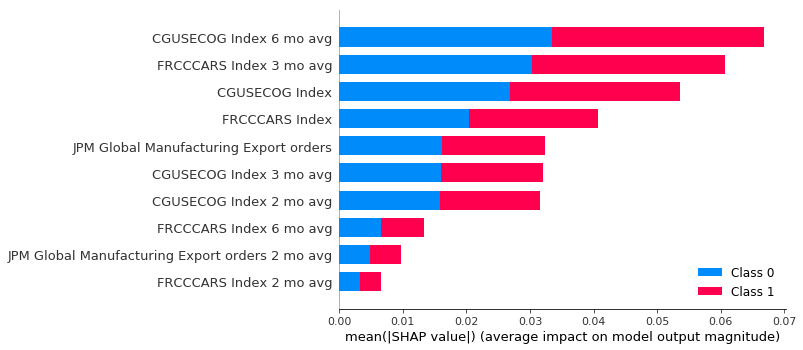

Eurostoxx 600


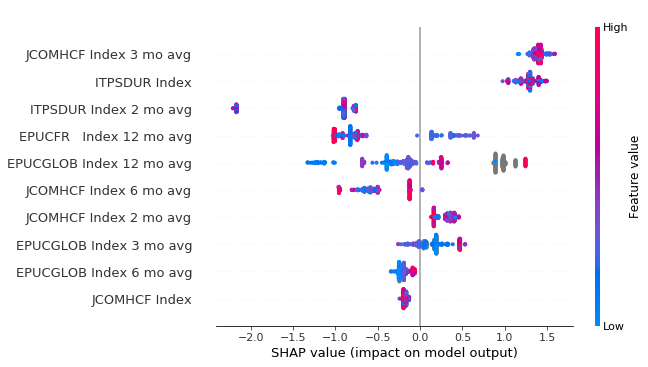

MSCI Japan


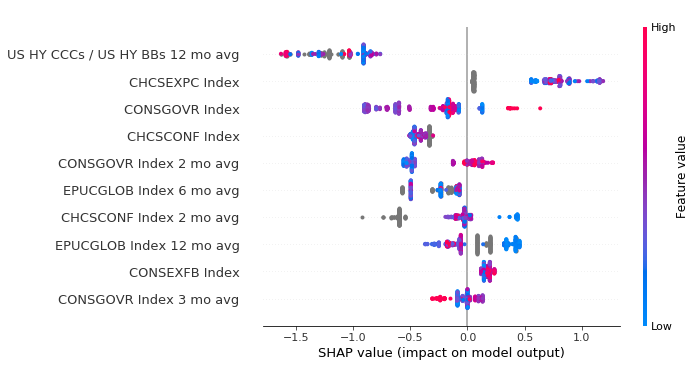

MSCI World


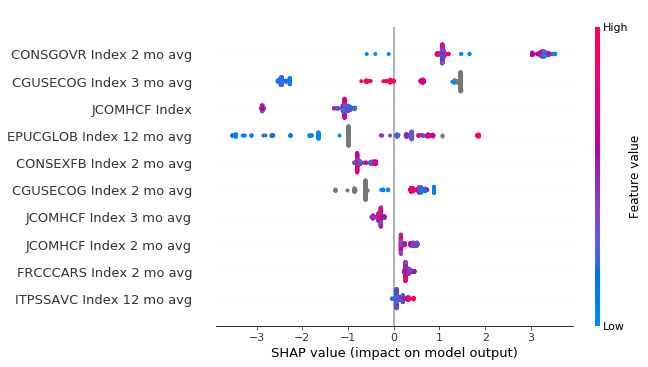

Russell 2000


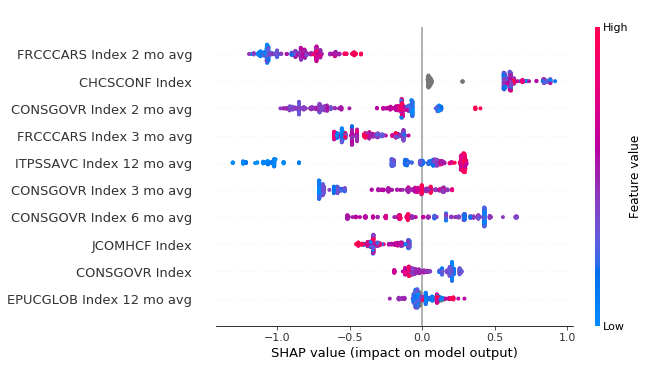

Crude Oil Total Return


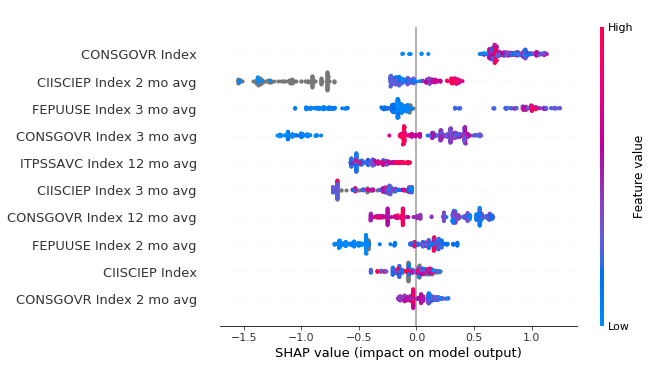

CRB Metals


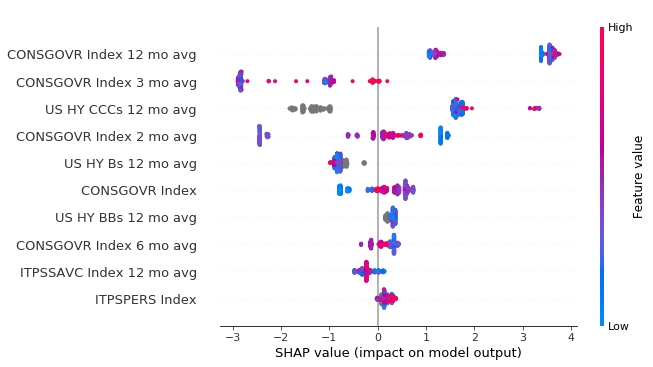

Gold Price
Model is not compatible for shap plot
S&P GSCI Total Return Index


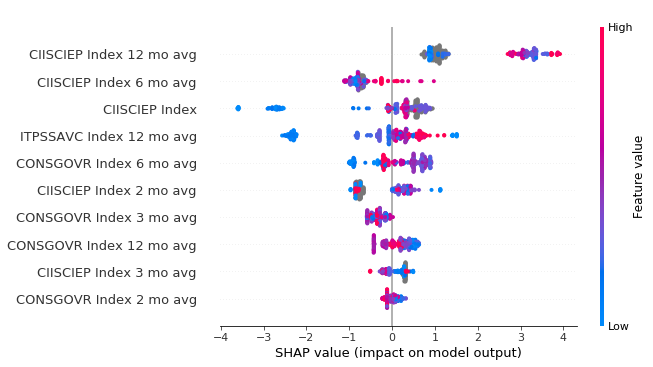

UST 7-10yr


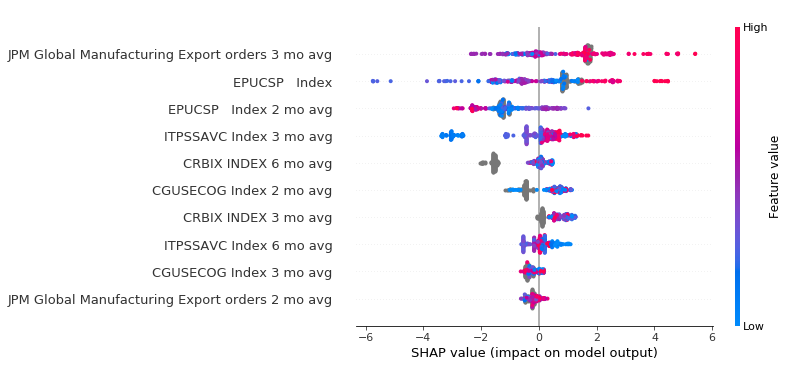

German 7-10yr
Model is not compatible for shap plot
US IG Corps


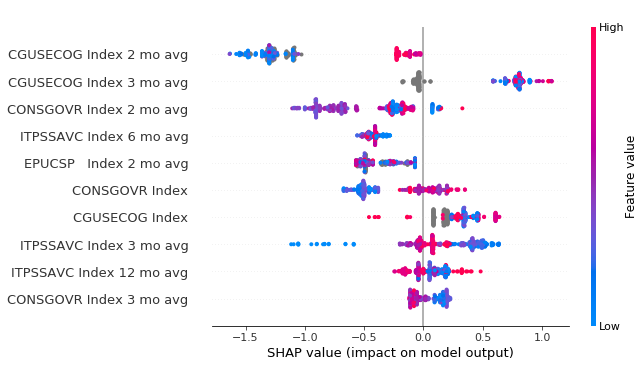

US HY Corp


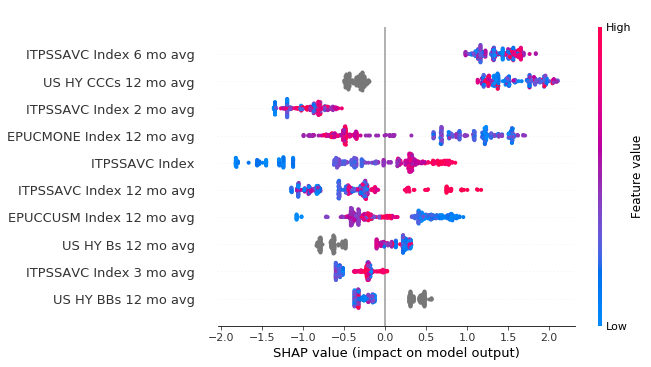

US Mortgages


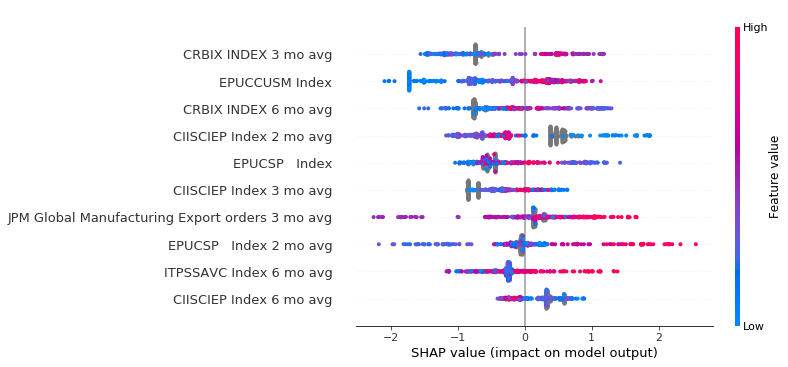

In [36]:
for asset_class in merge_1month_Y.columns.values:
    print(asset_class)
    shap_plot(features_classify_1m, model_classify_1m[0], merge_1month_X, asset_class)

### Precision

MSCI EM


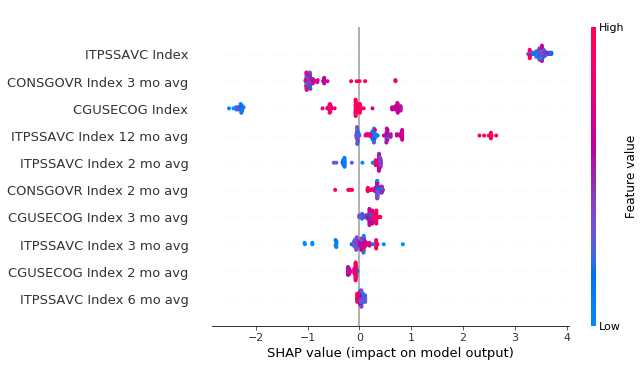

SPX 500 Price Return


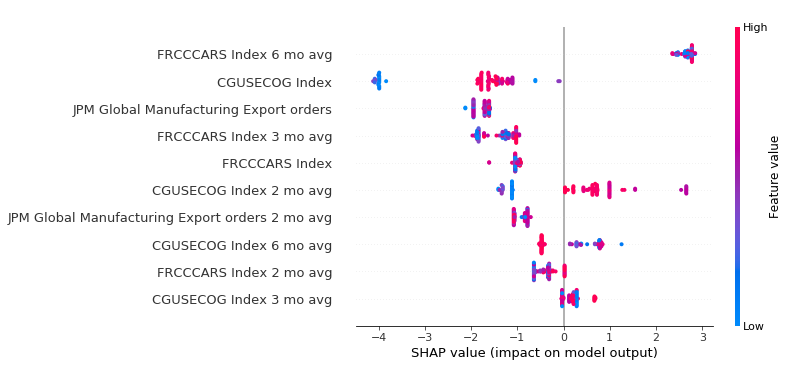

Eurostoxx 600


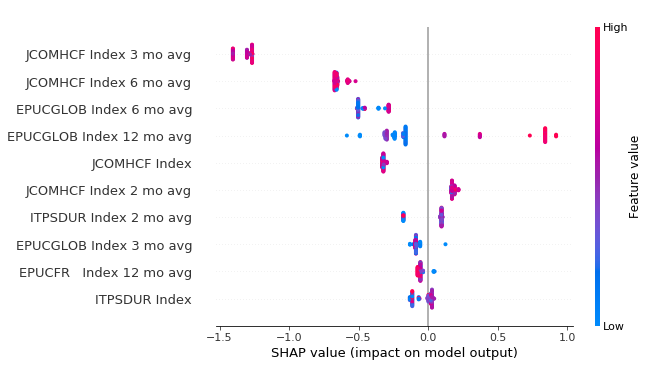

MSCI Japan


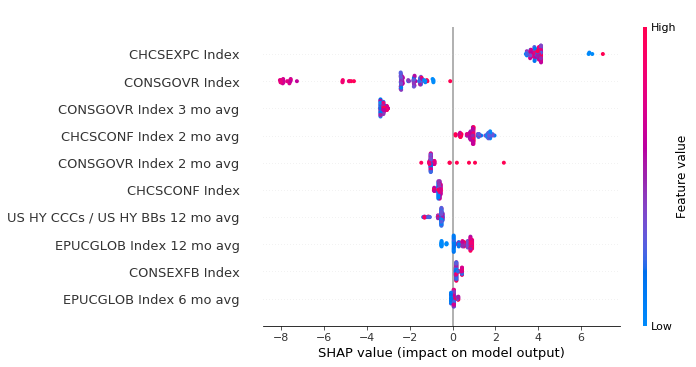

MSCI World


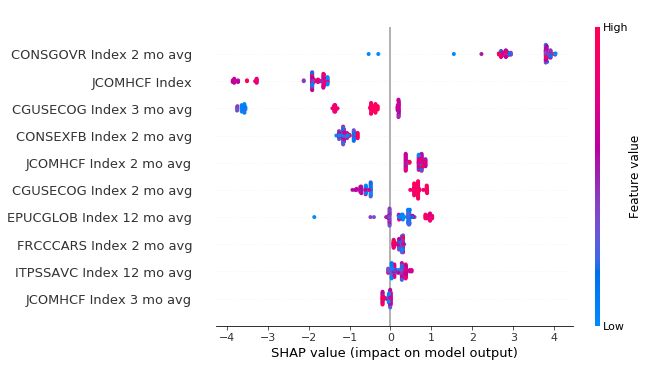

Russell 2000


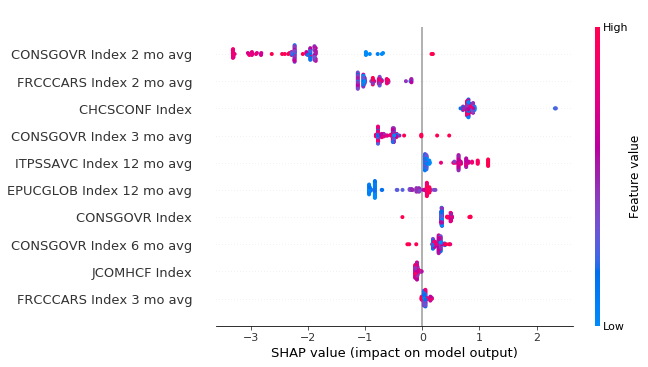

Crude Oil Total Return


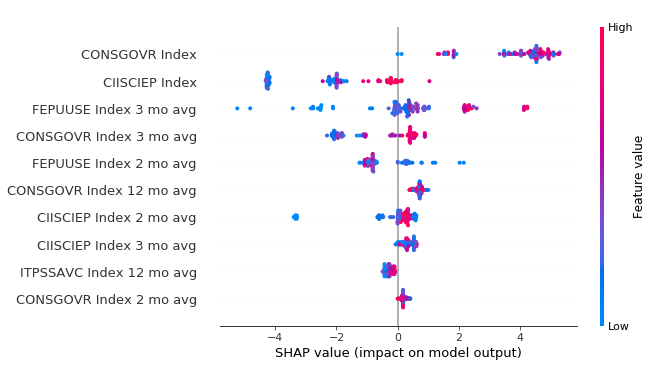

CRB Metals


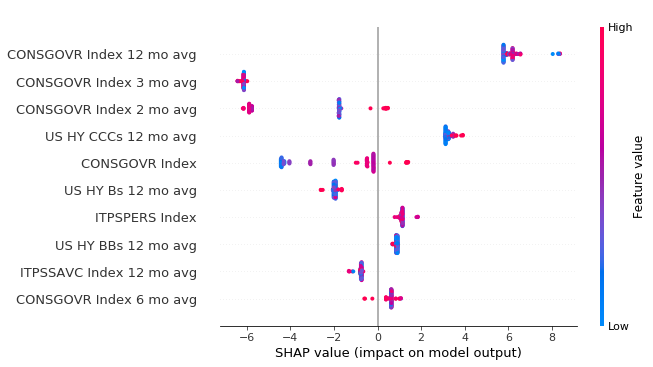

Gold Price
Model is not compatible for shap plot
S&P GSCI Total Return Index


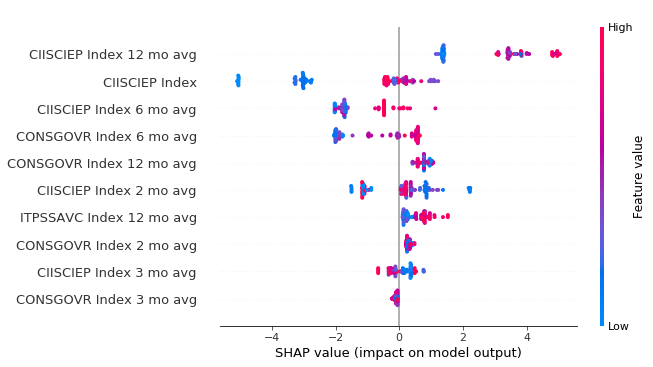

UST 7-10yr


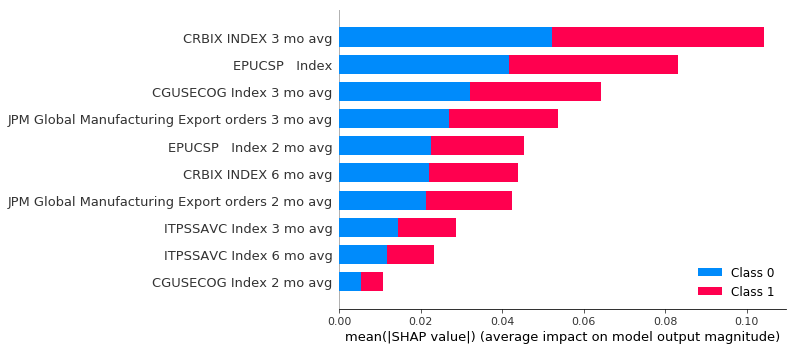

German 7-10yr


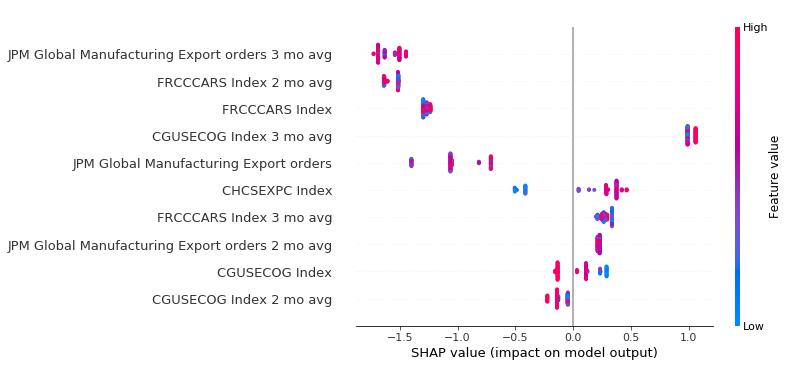

US IG Corps


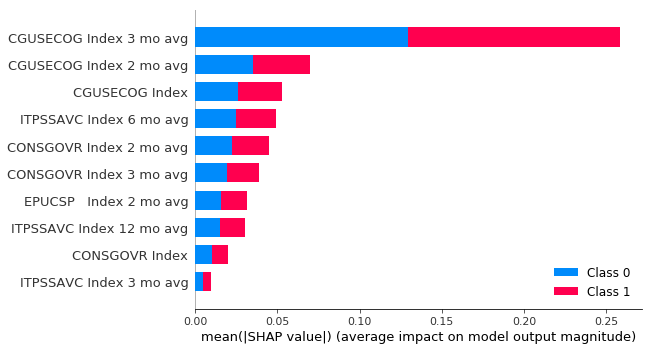

US HY Corp


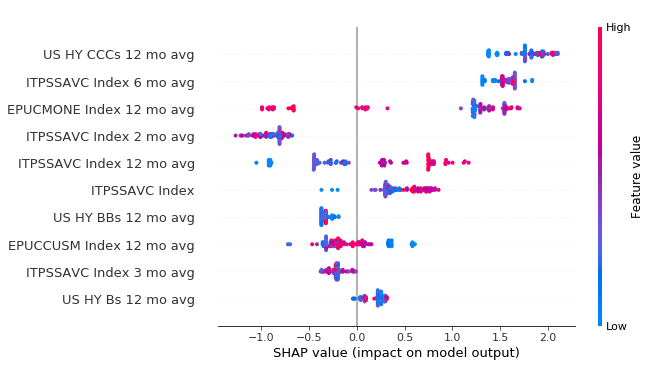

US Mortgages


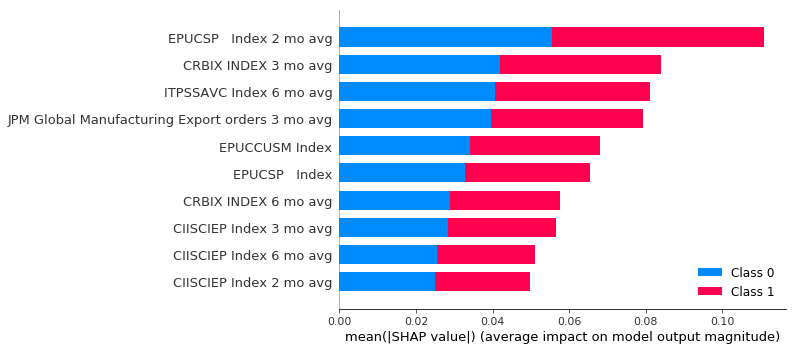

In [122]:
for asset_class in merge_1month_Y.columns.values:
    print(asset_class)
    shap_plot(features_classify_1m, model_classify_1m[1], merge_1month_X, asset_class)

### AUC-ROC

MSCI EM


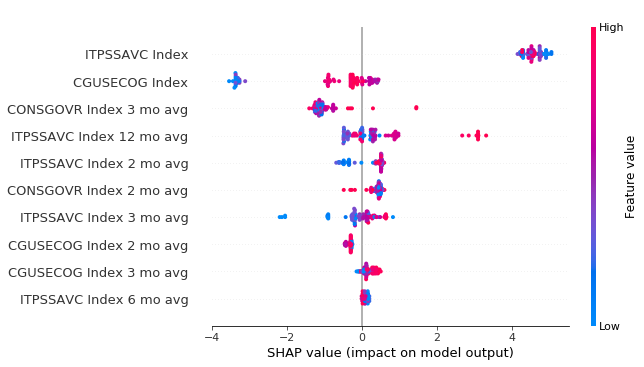

SPX 500 Price Return


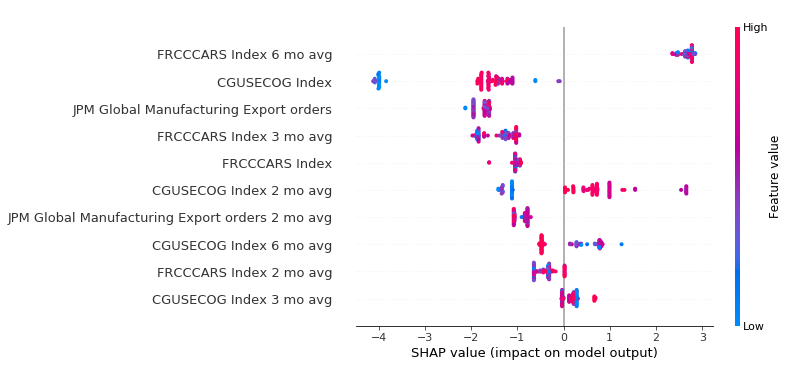

Eurostoxx 600


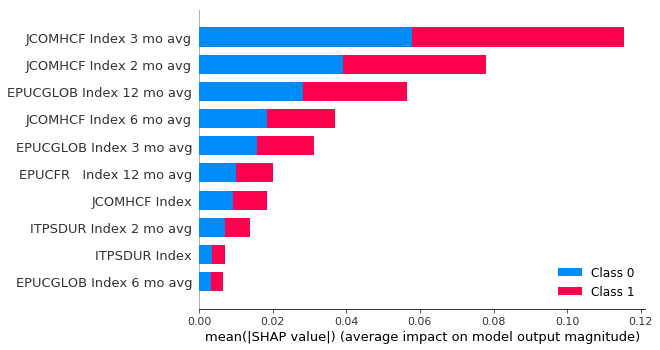

MSCI Japan


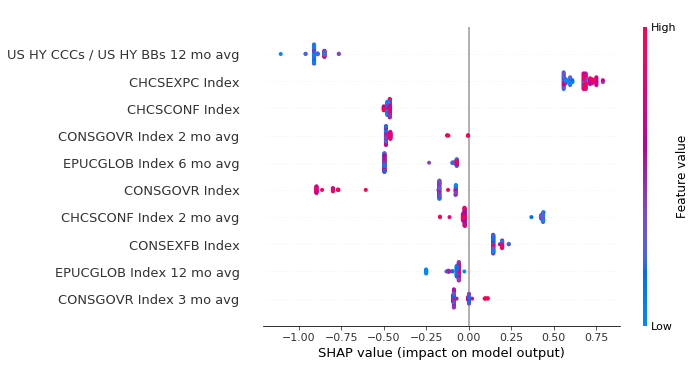

MSCI World


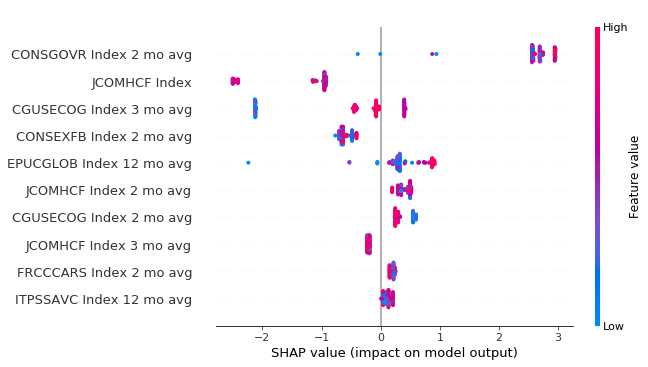

Russell 2000


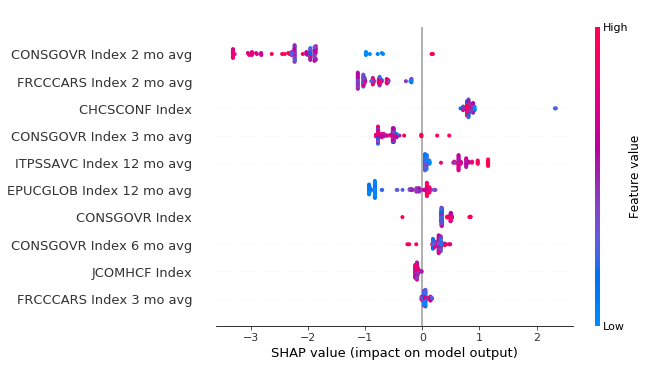

Crude Oil Total Return


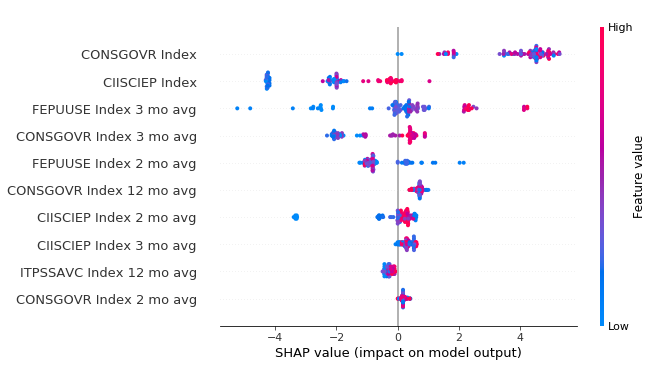

CRB Metals


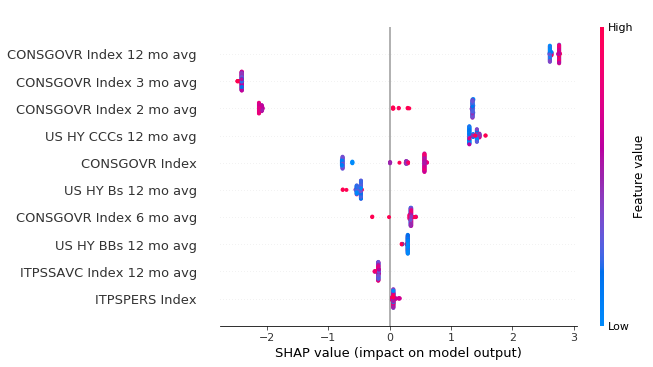

Gold Price
Model is not compatible for shap plot
S&P GSCI Total Return Index
Model is not compatible for shap plot
UST 7-10yr


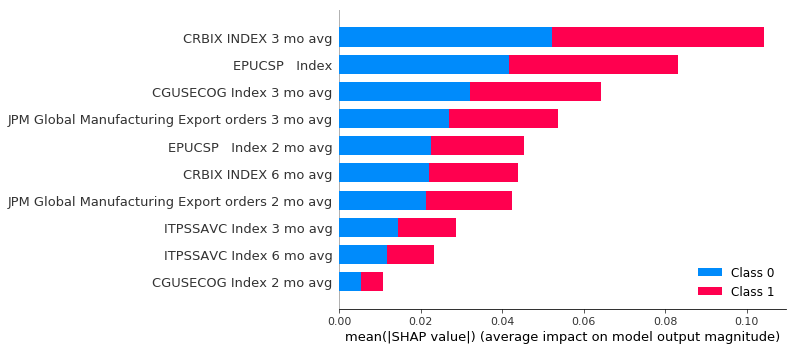

German 7-10yr
Model is not compatible for shap plot
US IG Corps


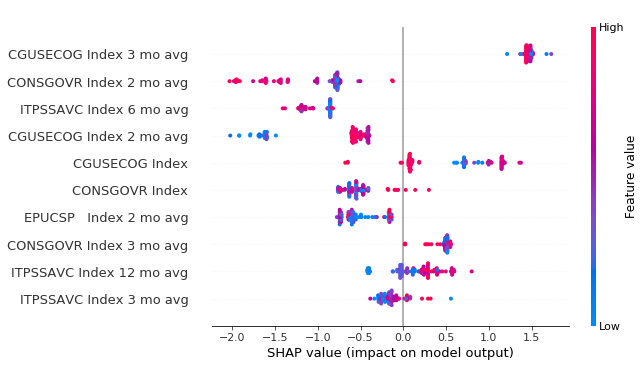

US HY Corp


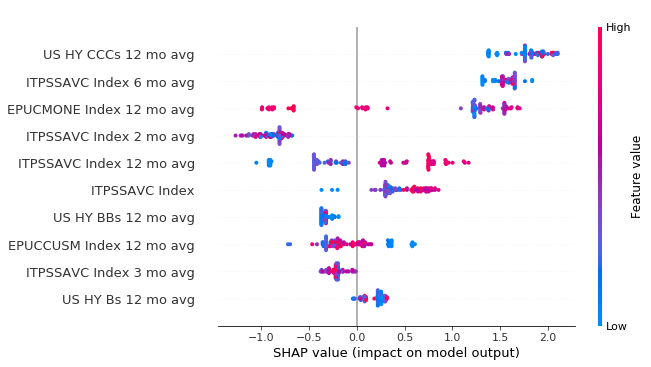

US Mortgages
Model is not compatible for shap plot


In [123]:
for asset_class in merge_1month_Y.columns.values:
    print(asset_class)
    shap_plot(features_classify_1m, model_classify_1m[2], merge_1month_X, asset_class)

## Three Month Prediction (This takes a long time to run)

In [12]:
merge_3month_X = merge_3month[merge_3month.columns[:-15]]
merge_3month_X = merge_3month_X.replace([np.inf, -np.inf], np.nan)
merge_3month_Y = merge_3month[merge_3month.columns[-15:]].applymap(lambda x: cont_2_binary(x))

In [13]:
metric_classify_3m, model_classify_3m, features_classify_3m = metric_model_feature_table(
                                 merge_3month_X, merge_3month_Y, pool_classifier, 
                                    [accuracy_score, average_precision_score, roc_auc_score], 
                                        [False, True, True], ['Accuracy','Precision','AUC-ROC'])

In [201]:
# can replace model_classify_3m[0] (accuracy) with model_classify_3m[1] (precision) or model_classify_3m[2] (auc-roc)
generate_pred_all_assets(model_classify_3m[0], features_classify_3m, merge_3month_X, merge_3month_Y, 
                         Date_3month, 'pred_3month.csv')

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
Date                                                                            
1988-03      1.0                   1.0            1.0         1.0         1.0   
1988-04      1.0                   1.0            1.0         1.0         1.0   
1988-05      1.0                   1.0            1.0         1.0         1.0   
1988-06      1.0                   1.0            1.0         1.0         1.0   
1988-07      1.0                   1.0            1.0         1.0        -1.0   
...          ...                   ...            ...         ...         ...   
2019-04      1.0                   1.0            1.0         1.0         1.0   
2019-05      1.0                   1.0            1.0         1.0         1.0   
2019-06      1.0                   1.0            1.0         1.0         1.0   
2019-07      1.0                   1.0            1.0         1.0         1.0   
2019-08      1.0                   1.0            1.0         1.0         1.0   

         Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
Date                                                                    
1988-03           1.0                     1.0         1.0         1.0   
1988-04           1.0                     1.0         1.0         1.0   
1988-05           1.0                     1.0         1.0         1.0   
1988-06           1.0                     1.0         1.0         1.0   
1988-07           1.0                     1.0         1.0         1.0   
...               ...                     ...         ...         ...   
2019-04           1.0                     1.0         1.0         1.0   
2019-05           1.0                     1.0         1.0         1.0   
2019-06           1.0                     1.0         1.0         1.0   
2019-07           1.0                     1.0         1.0         1.0   
2019-08           1.0                     1.0         1.0         1.0   

         S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
Date                                                                           
1988-03                          1.0         1.0           -1.0          1.0   
1988-04                          1.0         1.0           -1.0         -1.0   
1988-05                          1.0         1.0           -1.0          1.0   
1988-06                          1.0         1.0           -1.0          1.0   
1988-07                          1.0         1.0           -1.0         -1.0   
...                              ...         ...            ...          ...   
2019-04                          1.0        -1.0           -1.0          1.0   
2019-05                          1.0        -1.0           -1.0          1.0   
2019-06                          1.0         1.0           -1.0          1.0   
2019-07                          1.0        -1.0           -1.0          1.0   
2019-08                          1.0        -1.0           -1.0          1.0   

         US HY Corp  US Mortgages  
Date                               
1988-03         1.0          -1.0  
1988-04         1.0          -1.0  
1988-05         1.0          -1.0  
1988-06         1.0          -1.0  
1988-07         1.0          -1.0  
...             ...           ...  
2019-04         1.0           1.0  
2019-05         1.0          -1.0  
2019-06         1.0          -1.0  
2019-07         1.0           1.0  
2019-08         1.0           1.0  

[378 rows x 15 columns]

### Accuracy

In [57]:
metric_classify_3m[0]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0    0.5417                0.9167         0.8750      0.4583      0.7917   
1    0.6667                0.8333         0.7917      0.6667      0.7917   
2    0.5417                0.6250         0.6250      0.5000      0.7083   
3    0.5000                0.4167         0.5000      0.6667      0.6250   
4    0.7083                0.6667         0.7917      0.5417      0.6250   
5    0.5000                0.7083         0.7917      0.4583      0.6250   
6    0.7917                0.7083         0.8333      0.5417      0.7500   
7    0.7500                0.6667         0.6250      0.6250      0.6250   
8    0.6667                0.5000         0.6250      0.5417      0.7500   
9    0.7083                0.8333         0.8750      0.6250      0.7083   
10   0.6250                0.5833         0.6667      0.5833      0.6250   
11   0.6250                0.9167         0.8333      0.6250      0.9167   
12   0.5833                0.7083         0.6250      0.7083      0.5833   
13   0.6667                0.7083         0.5417      0.6250      0.7917   
14   0.7917                0.7500         0.6667      0.5000      0.7917   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0         0.7500                  0.5833         NaN      0.8750   
1         0.6250                  0.4167         NaN      0.7083   
2         0.6667                  0.8750         NaN      0.6250   
3         0.5417                  0.5000         NaN      0.5000   
4         0.6667                  0.7500         NaN      0.3333   
5         0.6667                  0.6667         NaN      0.6250   
6         0.6667                  0.6250         NaN      0.7500   
7         0.5833                  0.6250         NaN      0.6667   
8         0.7917                  0.4583      0.7917      0.6250   
9         0.8333                  0.6250      0.5833      0.9167   
10        0.6667                  0.5417      0.5000      0.6667   
11        0.9167                  0.6667      0.6250      0.6667   
12        0.5417                  0.6250      0.5833      0.4583   
13        0.7500                  0.6667      0.5833      0.5417   
14        0.6667                  0.6250      0.5833      0.6250   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                        0.6250      0.7083         0.6667       0.6667   
1                        0.3750      0.5833         0.6667       0.5000   
2                        0.9583      0.5417         0.5417       0.3750   
3                        0.4167      0.6250         0.6250       0.4583   
4                        0.8333      0.5417         0.5833       0.3750   
5                        0.7917      0.6250         0.7083       0.5417   
6                        0.5417      0.4583         0.4583       0.5417   
7                        0.7083      0.5833         0.5000       0.5833   
8                        0.5833      0.5000         0.6667       0.8333   
9                        0.5833      0.6250         0.7500       0.7083   
10                       0.5000      0.5833         0.6667       0.2500   
11                       0.6250      0.5417         0.5833       0.6667   
12                       0.5833      0.6667         0.7500       0.5000   
13                       0.5000      0.6667         0.7083       0.6250   
14                       0.4583      0.4167         0.5417       0.8750   

    US HY Corp  US Mortgages  
0       0.6667        0.7500  
1       0.5833        0.7083  
2       0.8333        0.9167  
3       0.5417        0.6250  
4       0.7917        0.6250  
5       0.7500        0.6250  
6       0.5417        0.5000  
7       0.5000        0.5417  
8       0.8333        0.5000  
9       0.8333        0.5000  
10      0.6667        0.5833  
11      0.7500        0.7083  
12      0.7917        0.5833  
13      0.6667        0.7917  
14      0.7917        0.5000

In [58]:
model_classify_3m[0]

MSCI EM  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   ([DecisionTreeRegressor(criterion='friedman_ms...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   XGBClassifier(base_score=0.5, booster='gbtree'...   
5   XGBClassifier(base_score=0.5, booster='gbtree'...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   SVC(C=1.0, cache_size=200, class_weight=None, ...   
8   ([DecisionTreeRegressor(criterion='friedman_ms...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  SVC(C=1.0, cache_size=200, class_weight=None, ...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                 SPX 500 Price Return  \
0   XGBClassifier(base_score=0.5, booster='gbtree'...   
1   SVC(C=1.0, cache_size=200, class_weight=None, ...   
2   XGBClassifier(base_score=0.5, booster='gbtree'...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   XGBClassifier(base_score=0.5, booster='gbtree'...   
5   XGBClassifier(base_score=0.5, booster='gbtree'...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   XGBClassifier(base_score=0.5, booster='gbtree'...   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   XGBClassifier(base_score=0.5, booster='gbtree'...   
10  XGBClassifier(base_score=0.5, booster='gbtree'...   
11  XGBClassifier(base_score=0.5, booster='gbtree'...   
12  XGBClassifier(base_score=0.5, booster='gbtree'...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  XGBClassifier(base_score=0.5, booster='gbtree'...   

                                        Eurostoxx 600  \
0   SVC(C=1.0, cache_size=200, class_weight=None, ...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   XGBClassifier(base_score=0.5, booster='gbtree'...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   XGBClassifier(base_score=0.5, booster='gbtree'...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   XGBClassifier(base_score=0.5, booster='gbtree'...   
9   XGBClassifier(base_score=0.5, booster='gbtree'...   
10  SVC(C=1.0, cache_size=200, class_weight=None, ...   
11  XGBClassifier(base_score=0.5, booster='gbtree'...   
12  XGBClassifier(base_score=0.5, booster='gbtree'...   
13  XGBClassifier(base_score=0.5, booster='gbtree'...   
14  XGBClassifier(base_score=0.5, booster='gbtree'...   

                                           MSCI Japan  \
0   XGBClassifier(base_score=0.5, booster='gbtree'...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   SVC(C=1.0, cache_size=200, class_weight=None, ...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   XGBClassifier(base_score=0.5, booster='gbtree'...   
5   (DecisionTreeClassifier(class_weight=None, cri...   
6   XGBClassifier(base_score=0.5, booster='gbtree'...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   SVC(C=1.0, cache_size=200, class_weight=None, ...   
10  XGBClassifier(base_score=0.5, booster='gbtree'...   
11  ([DecisionTreeRegressor(criterion='friedman_ms...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  (DecisionTreeClassifier(class_weight=None, cri...   
14  XGBClassifier(base_score=0.5, booster='gbtree'...   

                                           MSCI World  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   SVC(C=1.0, cache_size=200, class_weight=None, ...   
5   XGBClassifier(base_score=0.5, booster='gbtree'..

### Precision

In [59]:
metric_classify_3m[1]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0    0.7795                0.9261         0.9400      0.7592      0.8367   
1    0.5804                0.9166         0.8941      0.8368      0.8925   
2    0.7463                0.8495         0.7830      0.5670      0.8511   
3    0.9103                0.4298         0.6511      0.8787      0.2550   
4    0.8241                0.7765         0.8967      0.6652      0.6720   
5    0.7966                0.8545         0.8792      0.7338      0.8433   
6    0.7970                0.7083         0.8520      0.7170      0.7500   
7    0.7500                0.8737         0.5858      0.6294      0.6259   
8    0.7907                0.5674         0.6761      0.4583      0.8361   
9    0.8353                0.9256         0.9461      0.7379      0.8689   
10   0.7916                0.6833         0.6667      0.4423      0.7343   
11   0.7575                0.9881         0.9365      0.8048      0.9167   
12   0.5691                0.7344         0.8403      0.8892      0.7363   
13   0.9201                0.9094         0.5174      0.6087      0.9506   
14   0.9710                0.9219         0.8472      0.6787      0.9781   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0         0.9167                  0.6691         NaN      0.5436   
1         0.6576                  0.4167         NaN      0.2917   
2         0.7607                  0.8750         NaN      0.4952   
3         0.5748                  0.6307         NaN      0.5000   
4         0.7511                  0.9392         NaN      0.8246   
5         0.7578                  0.7136         NaN      0.8156   
6         0.8098                  0.6251         NaN      0.7774   
7         0.7020                  0.7841         NaN      0.6667   
8         0.9615                  0.6801      0.9488      0.6639   
9         0.9221                  0.6949      0.8100      0.9501   
10        0.6908                  0.5417      0.6899      0.8460   
11        0.9595                  0.6637      0.8433      0.5836   
12        0.8046                  0.6977      0.2621      0.4743   
13        0.8965                  0.7335      0.7003      0.6460   
14        0.8668                  0.6250      0.4734      0.7795   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                        0.7818      0.7813         0.8078       0.7011   
1                        0.5021      0.7221         0.8387       0.5000   
2                        0.9901      0.9693         0.7376       0.3333   
3                        0.6496      0.8213         0.6250       0.5433   
4                        0.9494      0.7728         0.8493       0.8627   
5                        0.7917      0.7093         0.8679       0.5617   
6                        0.6645      0.3844         0.5808       0.3758   
7                        0.8271      0.6916         0.5000       0.4756   
8                        0.7484      0.5136         0.7512       0.9207   
9                        0.7565      0.6250         0.9057       0.7172   
10                       0.7221      0.9052         0.7588       0.9626   
11                       0.7557      0.5420         0.5904       0.8450   
12                       0.3929      0.8730         0.8781       0.6357   
13                       0.7609      0.8246         0.7372       0.7785   
14                       0.5833      0.4221         0.7851       0.9457   

    US HY Corp  US Mortgages  
0       0.7965        0.8887  
1       0.5956        0.8164  
2       0.3452        0.8914  
3       0.5405        0.8463  
4       0.9601        0.8135  
5       0.9359        0.5775  
6       0.5417        0.6332  
7       0.5393        0.6154  
8       0.9730        0.5076  
9       0.8775        0.6998  
10      0.8241        0.7401  
11      0.8076        0.5769  
12      0.5852        0.7440  
13      0.6667        0.8916  
14      0.8424        0.4483

In [60]:
model_classify_3m[1]

MSCI EM  \
0   (DecisionTreeClassifier(class_weight=None, cri...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   (DecisionTreeClassifier(class_weight=None, cri...   
4   XGBClassifier(base_score=0.5, booster='gbtree'...   
5   (DecisionTreeClassifier(class_weight=None, cri...   
6   XGBClassifier(base_score=0.5, booster='gbtree'...   
7   SVC(C=1.0, cache_size=200, class_weight=None, ...   
8   XGBClassifier(base_score=0.5, booster='gbtree'...   
9   (DecisionTreeClassifier(class_weight=None, cri...   
10  SVC(C=1.0, cache_size=200, class_weight=None, ...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  (DecisionTreeClassifier(class_weight=None, cri...   
14  (DecisionTreeClassifier(class_weight=None, cri...   

                                 SPX 500 Price Return  \
0   SVC(C=1.0, cache_size=200, class_weight=None, ...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   XGBClassifier(base_score=0.5, booster='gbtree'...   
3   SVC(C=1.0, cache_size=200, class_weight=None, ...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   XGBClassifier(base_score=0.5, booster='gbtree'...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   XGBClassifier(base_score=0.5, booster='gbtree'...   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   ([DecisionTreeRegressor(criterion='friedman_ms...   
10  (DecisionTreeClassifier(class_weight=None, cri...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  (DecisionTreeClassifier(class_weight=None, cri...   
13  ([DecisionTreeRegressor(criterion='friedman_ms...   
14  (DecisionTreeClassifier(class_weight=None, cri...   

                                        Eurostoxx 600  \
0   XGBClassifier(base_score=0.5, booster='gbtree'...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   (DecisionTreeClassifier(class_weight=None, cri...   
4   XGBClassifier(base_score=0.5, booster='gbtree'...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   (DecisionTreeClassifier(class_weight=None, cri...   
8   XGBClassifier(base_score=0.5, booster='gbtree'...   
9   (DecisionTreeClassifier(class_weight=None, cri...   
10  SVC(C=1.0, cache_size=200, class_weight=None, ...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  ([DecisionTreeRegressor(criterion='friedman_ms...   
14  XGBClassifier(base_score=0.5, booster='gbtree'...   

                                           MSCI Japan  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   SVC(C=1.0, cache_size=200, class_weight=None, ...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   XGBClassifier(base_score=0.5, booster='gbtree'...   
5   (DecisionTreeClassifier(class_weight=None, cri...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   XGBClassifier(base_score=0.5, booster='gbtree'...   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   (DecisionTreeClassifier(class_weight=None, cri...   
10  ([DecisionTreeRegressor(criterion='friedman_ms...   
11  XGBClassifier(base_score=0.5, booster='gbtree'...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  XGBClassifier(base_score=0.5, booster='gbtree'...   

                                           MSCI World  \
0   XGBClassifier(base_score=0.5, booster='gbtree'...   
1   (DecisionTreeClassifier(class_weight=None, cri...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   ([DecisionTreeRegressor(criterion='friedman_ms...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ..

### AUC-ROC

In [61]:
metric_classify_3m[2]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0    0.7708                0.5000         0.6746      0.7413      0.5842   
1    0.6250                0.5875         0.6263      0.8322      0.5842   
2    0.6538                0.7778         0.6296      0.5417      0.8571   
3    0.8963                0.7130         0.6875      0.9412      0.5158   
4    0.6723                0.6993         0.8392      0.5556      0.5000   
5    0.5000                0.6975         0.6632      0.5586      0.6815   
6    0.5684                0.5000         0.5125      0.5042      0.5000   
7    0.5000                0.8214         0.5105      0.6181      0.5000   
8    0.6783                0.5799         0.5035      0.5000      0.7500   
9    0.5966                0.8194         0.8571      0.7259      0.6975   
10   0.6889                0.5000         0.5000      0.5630      0.5407   
11   0.6222                0.8636         0.6875      0.5630      0.5000   
12   0.6519                0.5000         0.6704      0.7617      0.6294   
13   0.8242                0.7479         0.5699      0.5500      0.8697   
14   0.9519                0.8194         0.8217      0.6250      0.9259   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0         0.7941                  0.5357         NaN      0.7937   
1         0.6119                  0.5000         NaN      0.5000   
2         0.6393                  0.5000         NaN      0.5630   
3         0.5105                  0.5417         NaN      0.5000   
4         0.6602                  0.8611         NaN      0.5789   
5         0.5664                  0.5000         NaN      0.6259   
6         0.7266                  0.6000         NaN      0.5168   
7         0.5286                  0.5852         NaN      0.5000   
8         0.9214                  0.6119      0.9301      0.5704   
9         0.7778                  0.5643      0.6857      0.6477   
10        0.5000                  0.5000      0.5660      0.7571   
11        0.7222                  0.5214      0.6963      0.5000   
12        0.7517                  0.7344      0.5789      0.5078   
13        0.7815                  0.8333      0.5357      0.6608   
14        0.7773                  0.5000      0.5750      0.6148   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                        0.6857      0.6806         0.7259       0.5764   
1                        0.5234      0.5571         0.7031       0.5000   
2                        0.7826      0.9514         0.7429       0.5000   
3                        0.5571      0.7148         0.5000       0.5000   
4                        0.7750      0.7273         0.7714       0.7812   
5                        0.5000      0.7832         0.8151       0.5385   
6                        0.6434      0.5630         0.5455       0.5556   
7                        0.6849      0.5714         0.5000       0.5643   
8                        0.7028      0.5857         0.6406       0.9393   
9                        0.6500      0.5000         0.8151       0.5000   
10                       0.5590      0.8438         0.6484       0.8188   
11                       0.6493      0.5769         0.5000       0.7259   
12                       0.5714      0.7578         0.6713       0.6154   
13                       0.7929      0.6484         0.6944       0.6786   
14                       0.5286      0.5000         0.6736       0.9476   

    US HY Corp  US Mortgages  
0       0.5234        0.8392  
1       0.5315        0.7000  
2       0.6750        0.9371  
3       0.6387        0.7296  
4       0.8611        0.6741  
5       0.8487        0.6857  
6       0.5000        0.6250  
7       0.5000        0.5000  
8       0.9453        0.5000  
9       0.7037        0.5778  
10      0.6680        0.6357  
11      0.5926        0.6000  
12      0.7963        0.6224  
13      0.5000        0.8357  
14      0.8704        0.5000

In [62]:
model_classify_3m[2]

MSCI EM  \
0   (DecisionTreeClassifier(class_weight=None, cri...   
1   SVC(C=1.0, cache_size=200, class_weight=None, ...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   (DecisionTreeClassifier(class_weight=None, cri...   
4   XGBClassifier(base_score=0.5, booster='gbtree'...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   SVC(C=1.0, cache_size=200, class_weight=None, ...   
8   ([DecisionTreeRegressor(criterion='friedman_ms...   
9   (DecisionTreeClassifier(class_weight=None, cri...   
10  SVC(C=1.0, cache_size=200, class_weight=None, ...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  (DecisionTreeClassifier(class_weight=None, cri...   
14  (DecisionTreeClassifier(class_weight=None, cri...   

                                 SPX 500 Price Return  \
0   SVC(C=1.0, cache_size=200, class_weight=None, ...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   XGBClassifier(base_score=0.5, booster='gbtree'...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   XGBClassifier(base_score=0.5, booster='gbtree'...   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   ([DecisionTreeRegressor(criterion='friedman_ms...   
10  SVC(C=1.0, cache_size=200, class_weight=None, ...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  SVC(C=1.0, cache_size=200, class_weight=None, ...   
13  ([DecisionTreeRegressor(criterion='friedman_ms...   
14  (DecisionTreeClassifier(class_weight=None, cri...   

                                        Eurostoxx 600  \
0   XGBClassifier(base_score=0.5, booster='gbtree'...   
1   (DecisionTreeClassifier(class_weight=None, cri...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   SVC(C=1.0, cache_size=200, class_weight=None, ...   
4   XGBClassifier(base_score=0.5, booster='gbtree'...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   (DecisionTreeClassifier(class_weight=None, cri...   
8   XGBClassifier(base_score=0.5, booster='gbtree'...   
9   (DecisionTreeClassifier(class_weight=None, cri...   
10  SVC(C=1.0, cache_size=200, class_weight=None, ...   
11  SVC(C=1.0, cache_size=200, class_weight=None, ...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  XGBClassifier(base_score=0.5, booster='gbtree'...   
14  XGBClassifier(base_score=0.5, booster='gbtree'...   

                                           MSCI Japan  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   XGBClassifier(base_score=0.5, booster='gbtree'...   
2   SVC(C=1.0, cache_size=200, class_weight=None, ...   
3   XGBClassifier(base_score=0.5, booster='gbtree'...   
4   XGBClassifier(base_score=0.5, booster='gbtree'...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   SVC(C=1.0, cache_size=200, class_weight=None, ...   
7   (DecisionTreeClassifier(class_weight=None, cri...   
8   SVC(C=1.0, cache_size=200, class_weight=None, ...   
9   (DecisionTreeClassifier(class_weight=None, cri...   
10  ([DecisionTreeRegressor(criterion='friedman_ms...   
11  XGBClassifier(base_score=0.5, booster='gbtree'...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  SVC(C=1.0, cache_size=200, class_weight=None, ...   
14  ([DecisionTreeRegressor(criterion='friedman_ms...   

                                           MSCI World  \
0   XGBClassifier(base_score=0.5, booster='gbtree'...   
1   (DecisionTreeClassifier(class_weight=None, cri...   
2   (DecisionTreeClassifier(class_weight=None, cri...   
3   SVC(C=1.0, cache_size=200, class_weight=None, ...   
4   SVC(C=1.0, cache_size=200, class_weight=None, ...   
5   SVC(C=1.0, cache_size=200, class_weight=None, ..

In [110]:
summary_classify_1m = summary_by_asset(metric_classify_1m, ['Accuracy','Precision','AUC-ROC'])
summary_classify_3m = summary_by_asset(metric_classify_3m, ['Accuracy','Precision','AUC-ROC'])

summary_classfy = pd.concat([summary_classify_1m, summary_classify_3m])
summary_classfy = summary_classfy.T
summary_classfy.columns = pd.MultiIndex.from_product([['1 month','3 month'], ['Accuracy','Precision','AUC-ROC']])
summary_classfy

1 month                    3 month            \
                            Accuracy Precision AUC-ROC Accuracy Precision   
MSCI EM                       0.6528    0.7255  0.6234   0.6472    0.7731   
SPX 500 Price Return          0.6472    0.7073  0.5966   0.7028    0.8005   
Eurostoxx 600                 0.6361    0.7006  0.6040   0.7111    0.8154   
MSCI Japan                    0.6056    0.6786  0.6527   0.5778    0.6982   
MSCI World                    0.6417    0.7131  0.6082   0.7194    0.7796   
Russell 2000                  0.6695    0.7373  0.6407   0.6833    0.8096   
Crude Oil Total Return        0.5833    0.6556  0.6230   0.6083    0.6865   
CRB Metals                    0.5833    0.6144  0.6020   0.6071    0.6809   
Gold Price                    0.6222    0.6372  0.5951   0.6445    0.6758   
S&P GSCI Total Return Index   0.6083    0.6788  0.5975   0.6055    0.7355   
UST 7-10yr                    0.5750    0.6543  0.5836   0.5778    0.6928   
German 7-10yr                 0.6250    0.7560  0.6520   0.6305    0.7553   
US IG Corps                   0.5861    0.6645  0.5993   0.5639    0.6766   
US HY Corp                    0.6611    0.7269  0.6742   0.7139    0.7124   
US Mortgages                  0.5889    0.6637  0.6025   0.6444    0.7169   

                                     
                            AUC-ROC  
MSCI EM                      0.6690  
SPX 500 Price Return         0.6798  
Eurostoxx 600                0.6749  
MSCI Japan                   0.6409  
MSCI World                   0.6499  
Russell 2000                 0.7047  
Crude Oil Total Return       0.5908  
CRB Metals                   0.6556  
Gold Price                   0.6109  
S&P GSCI Total Return Index  0.6428  
UST 7-10yr                   0.6323  
German 7-10yr                0.6692  
US IG Corps                  0.6503  
US HY Corp                   0.6701  
US Mortgages                 0.6644

In [123]:
save_pred_to_excel(model_classify_3m[0], features_classify_3m, merge_3month_X, merge_3month_Y, 'pred_3month.xlsx')

In [124]:
save_pred_to_excel(model_classify_3m[1], features_classify_3m, 
                   merge_3month_X, merge_3month_Y, 'pred_3month_precision.xlsx')

In [125]:
save_pred_to_excel(model_classify_3m[2], features_classify_3m, 
                   merge_3month_X, merge_3month_Y, 'pred_3month_auc_roc.xlsx')

## Shap Plot

### Accuracy

MSCI EM


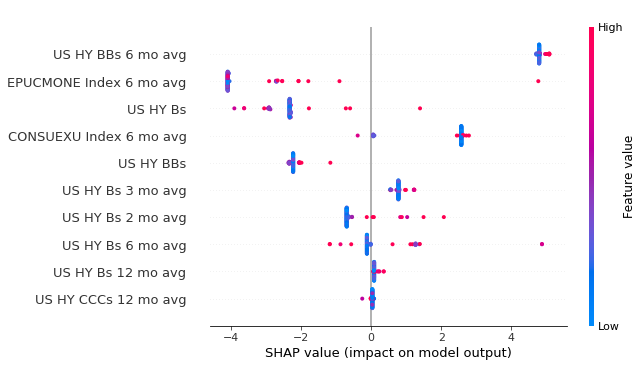

SPX 500 Price Return


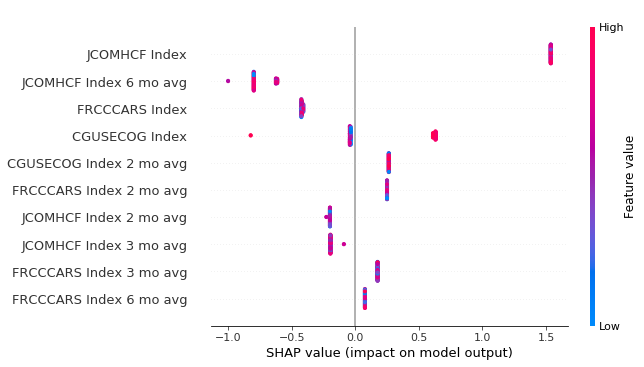

Eurostoxx 600


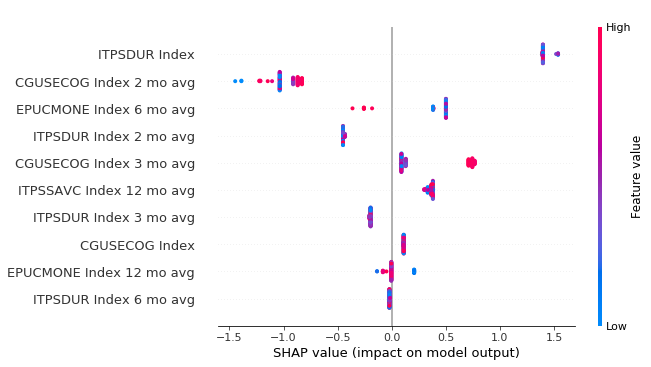

MSCI Japan


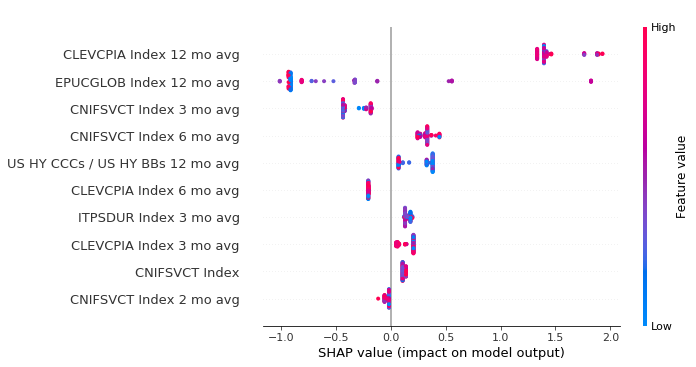

MSCI World


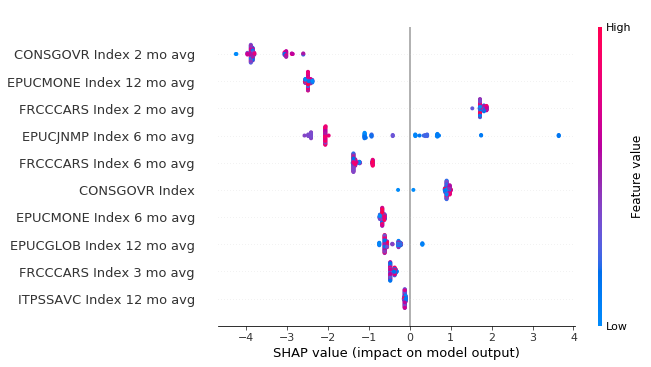

Russell 2000


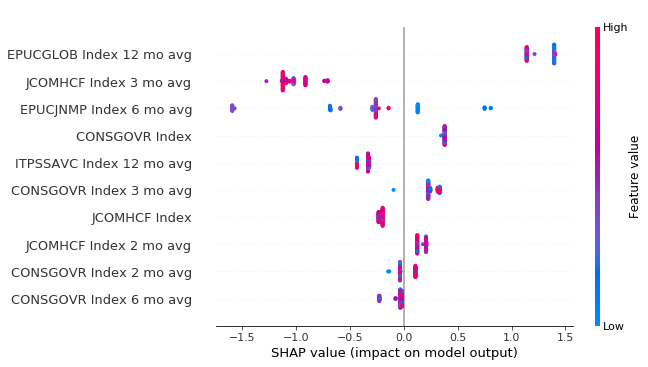

Crude Oil Total Return
Model is not compatible for shap plot
CRB Metals


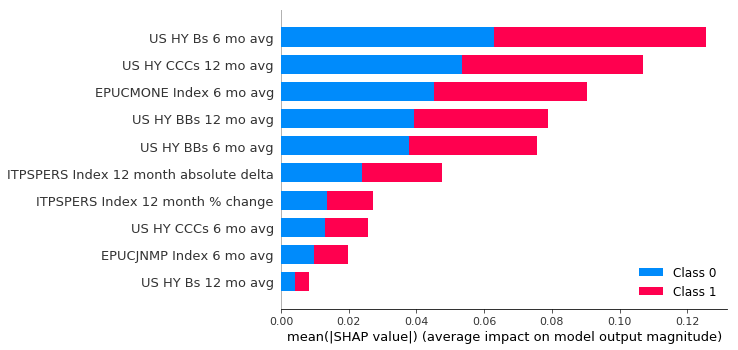

Gold Price
Model is not compatible for shap plot
S&P GSCI Total Return Index


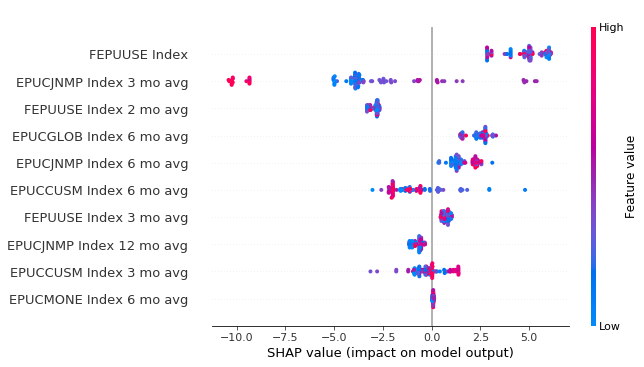

UST 7-10yr


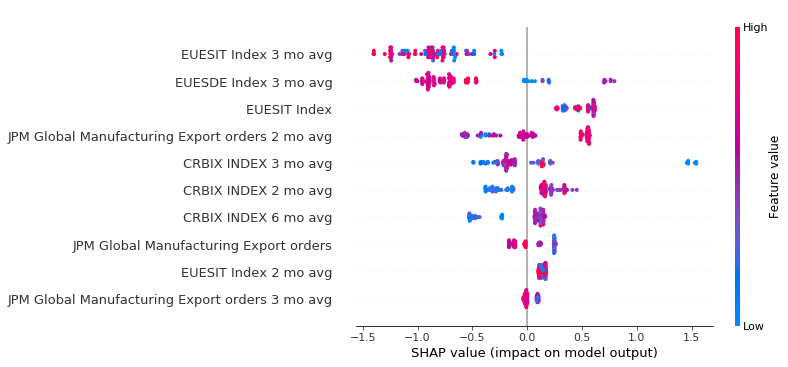

German 7-10yr


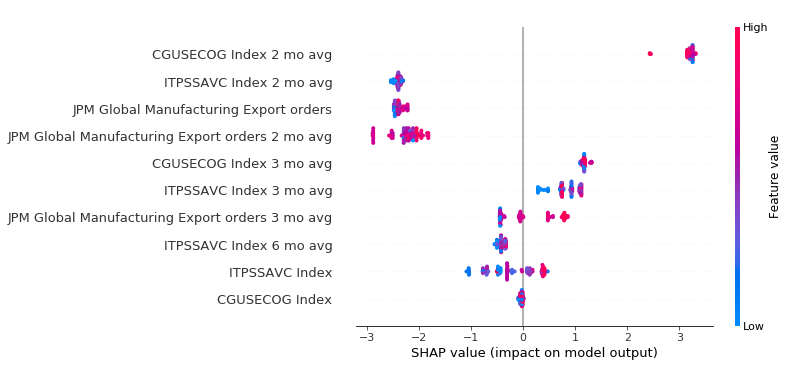

US IG Corps


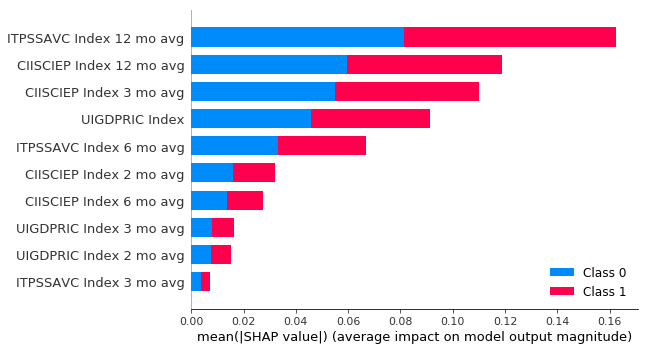

US HY Corp


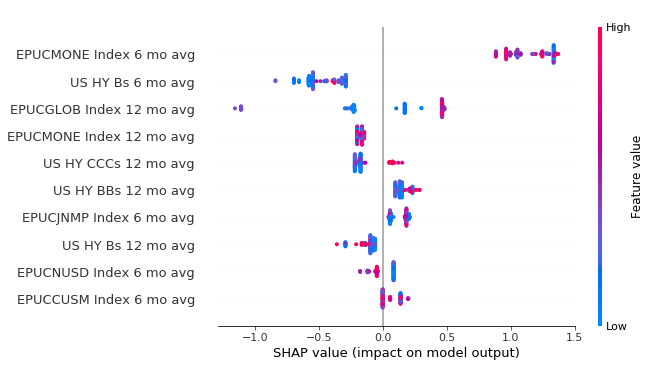

US Mortgages


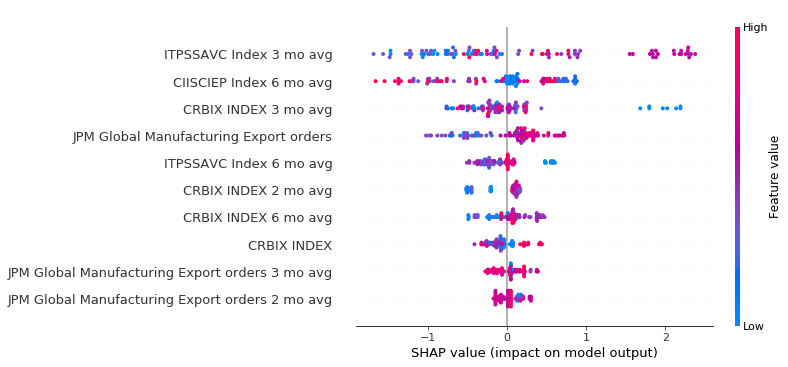

In [86]:
for asset_class in merge_3month_Y.columns.values:
    print(asset_class)
    shap_plot(features_classify_3m, model_classify_3m[0], merge_3month_X, asset_class)

### Precision

MSCI EM


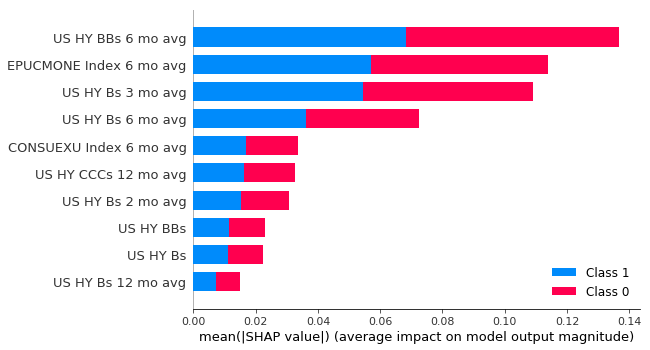

SPX 500 Price Return


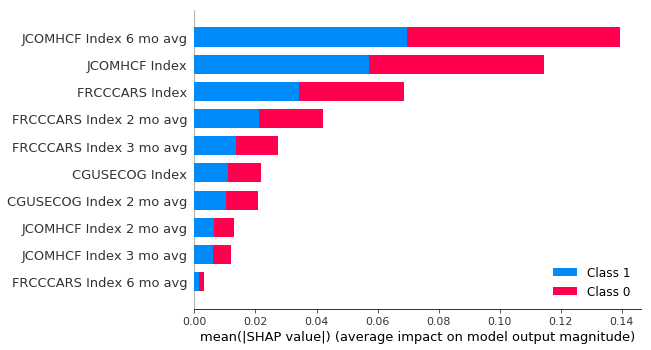

Eurostoxx 600


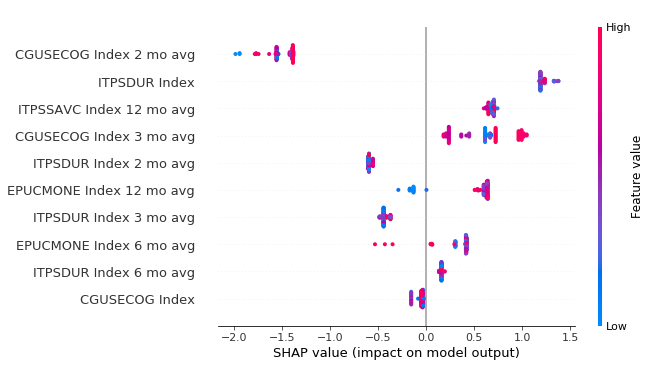

MSCI Japan


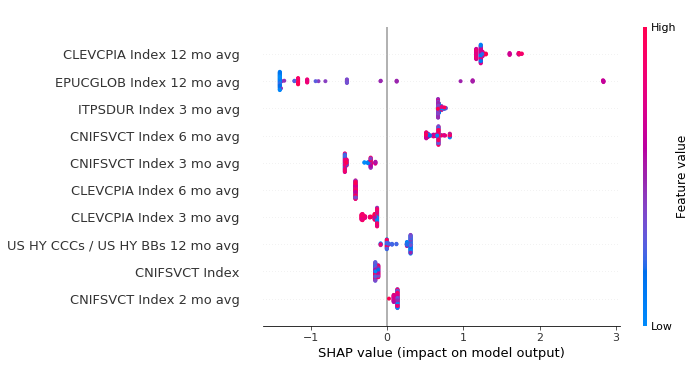

MSCI World


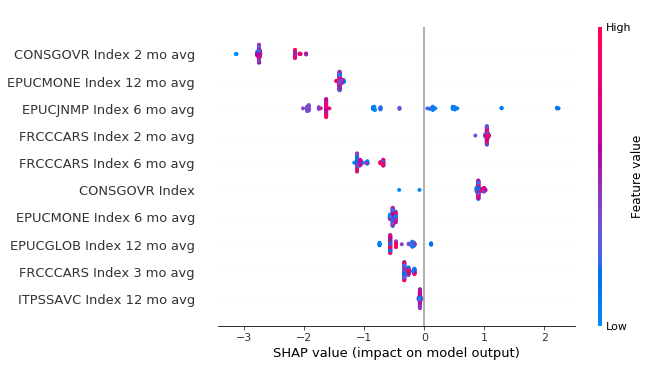

Russell 2000


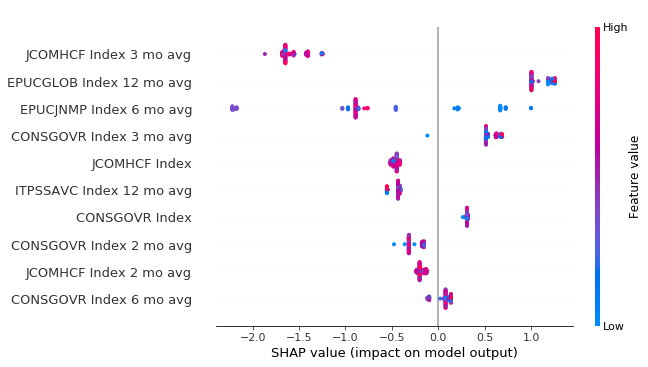

Crude Oil Total Return
Model is not compatible for shap plot
CRB Metals


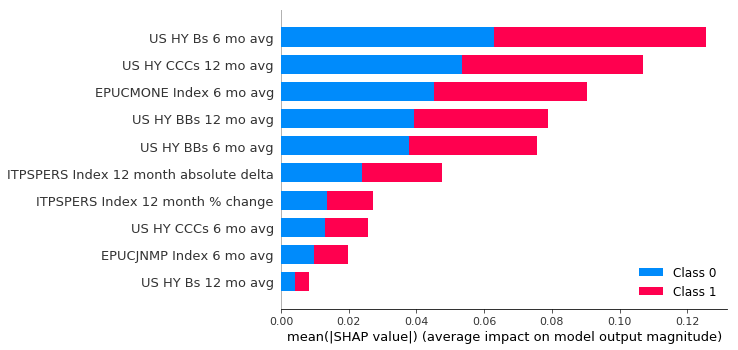

Gold Price


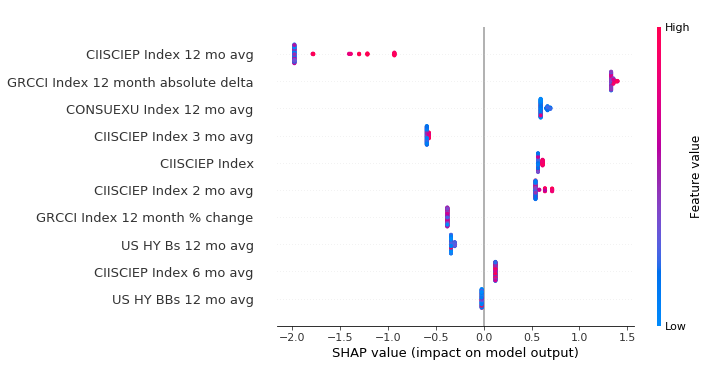

S&P GSCI Total Return Index
Model is not compatible for shap plot
UST 7-10yr


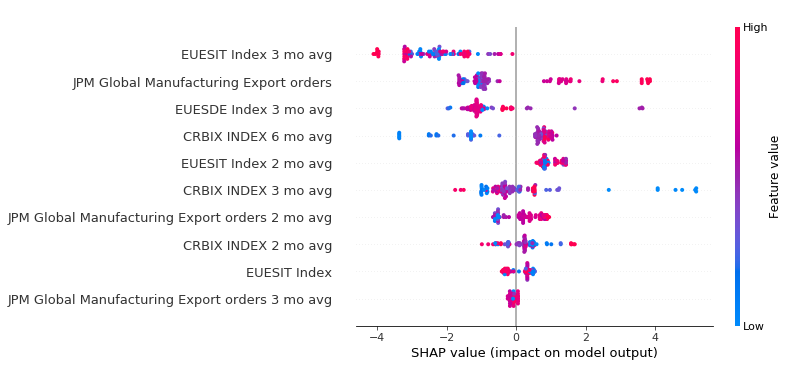

German 7-10yr


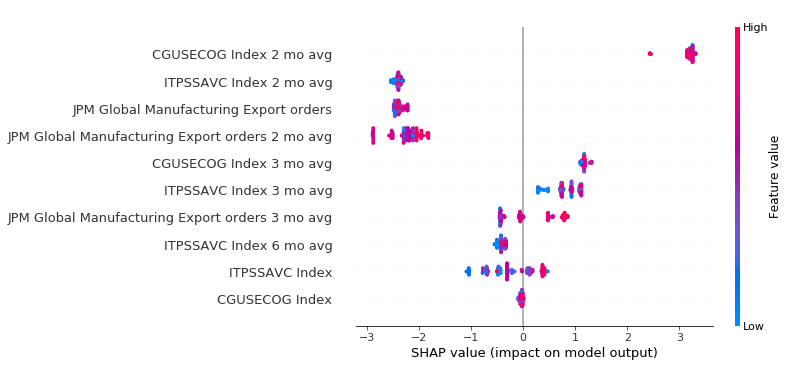

US IG Corps


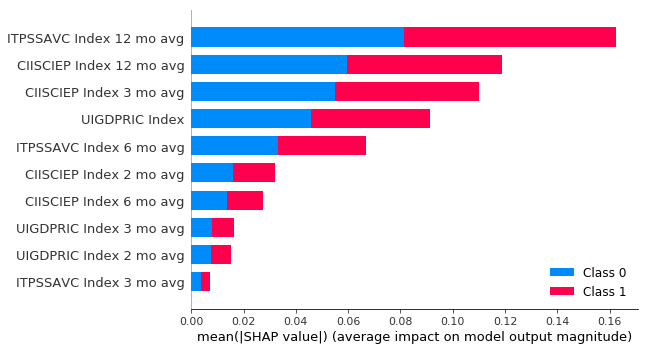

US HY Corp


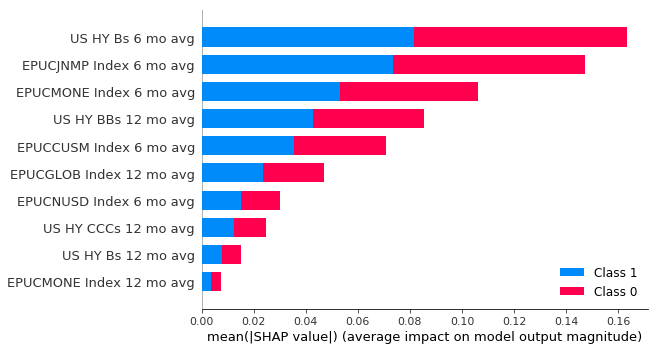

US Mortgages


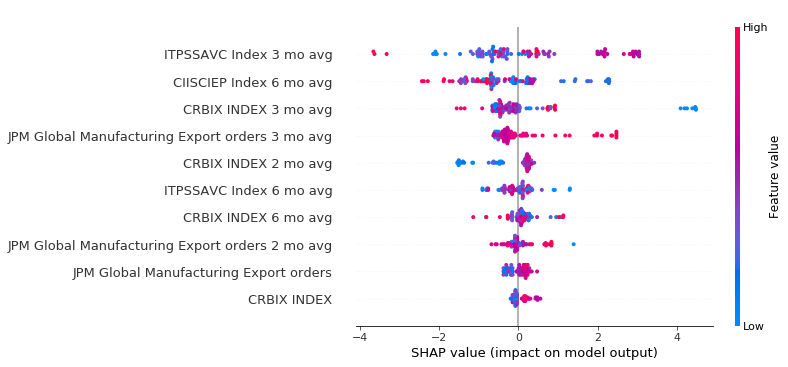

In [87]:
for asset_class in merge_3month_Y.columns.values:
    print(asset_class)
    shap_plot(features_classify_3m, model_classify_3m[1], merge_3month_X, asset_class)

### AUC-ROC

MSCI EM


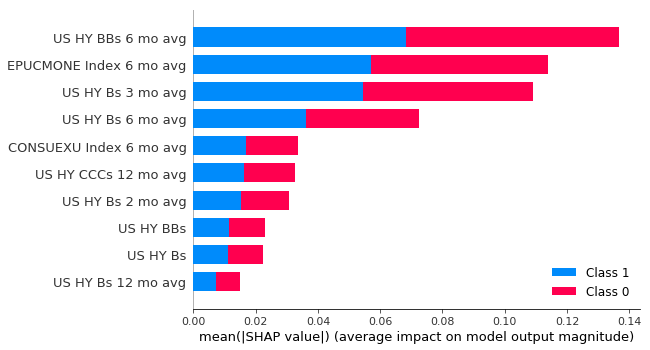

SPX 500 Price Return


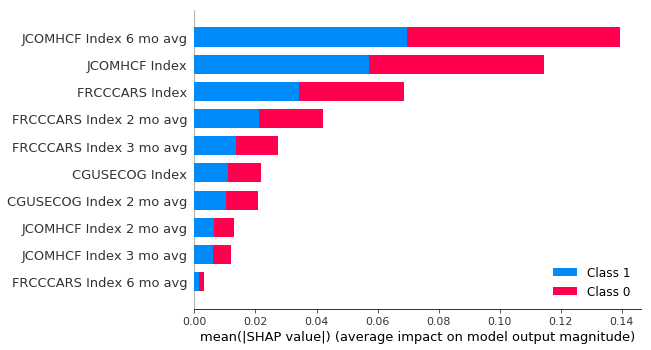

Eurostoxx 600


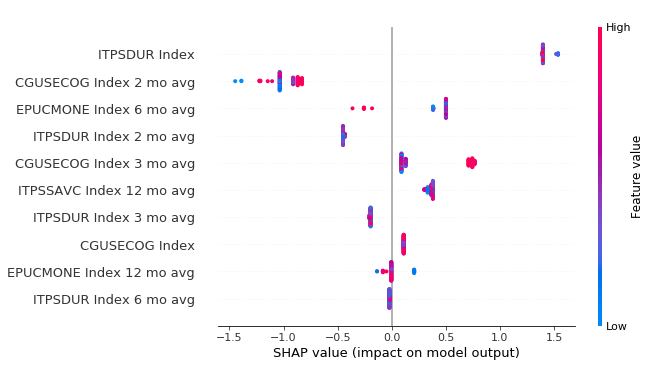

MSCI Japan


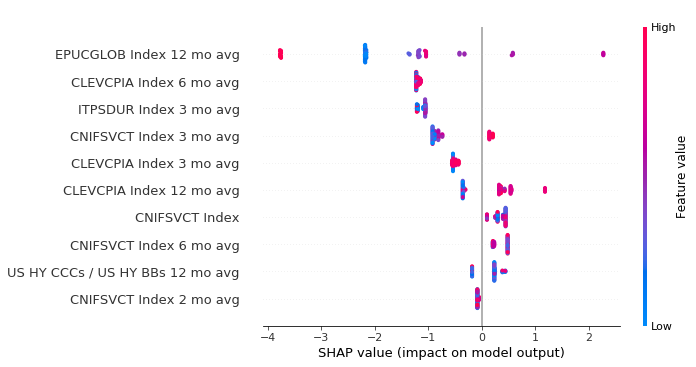

MSCI World


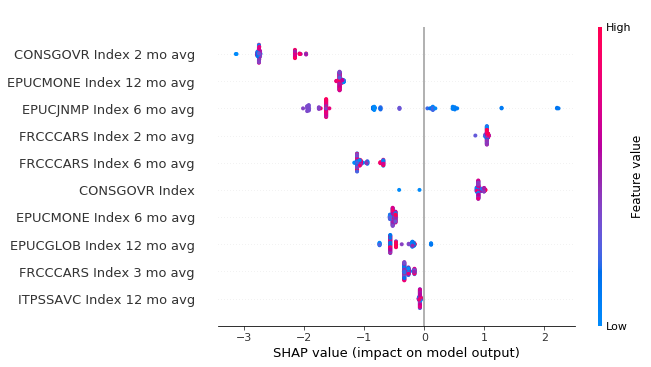

Russell 2000


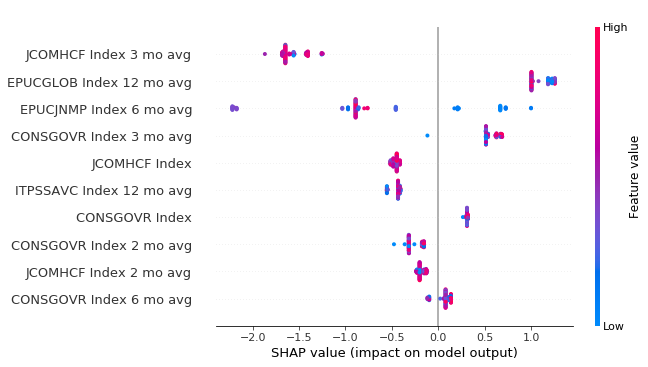

Crude Oil Total Return
Model is not compatible for shap plot
CRB Metals


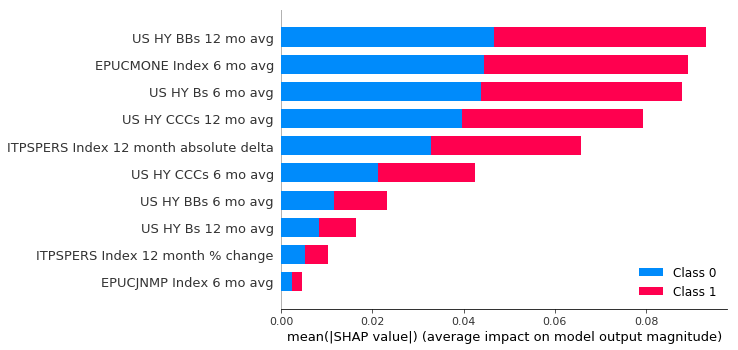

Gold Price


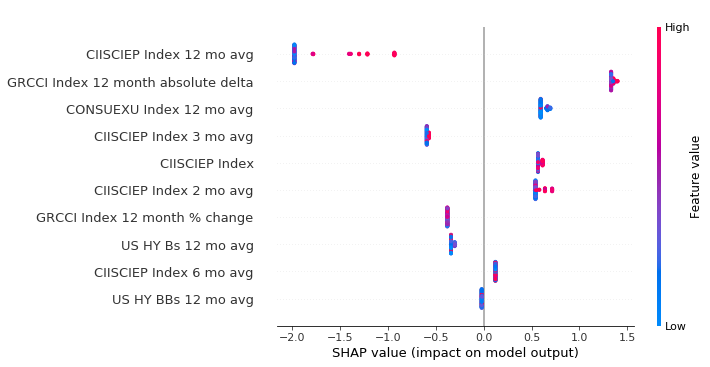

S&P GSCI Total Return Index


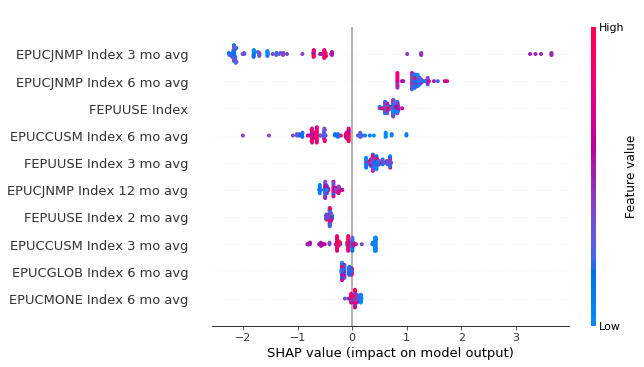

UST 7-10yr
Model is not compatible for shap plot
German 7-10yr


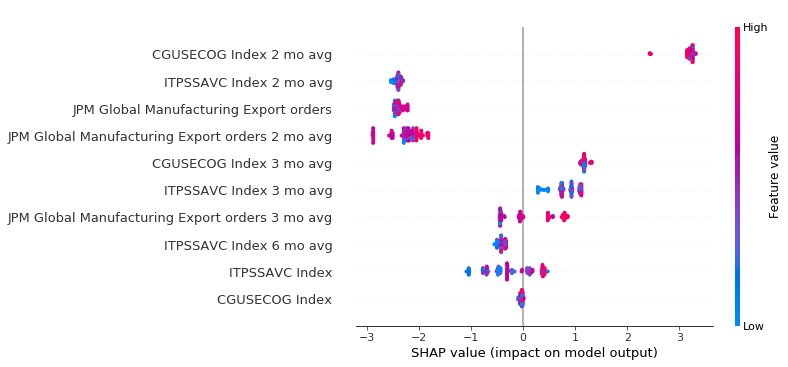

US IG Corps


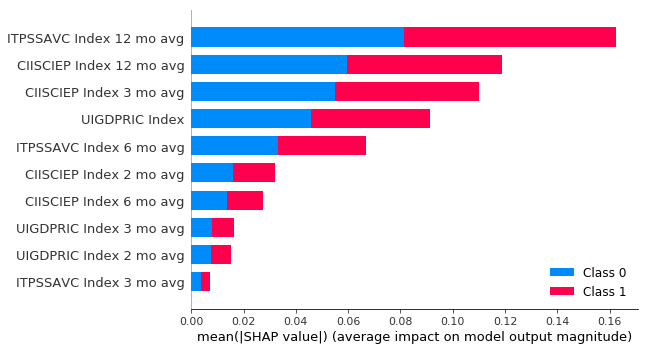

US HY Corp


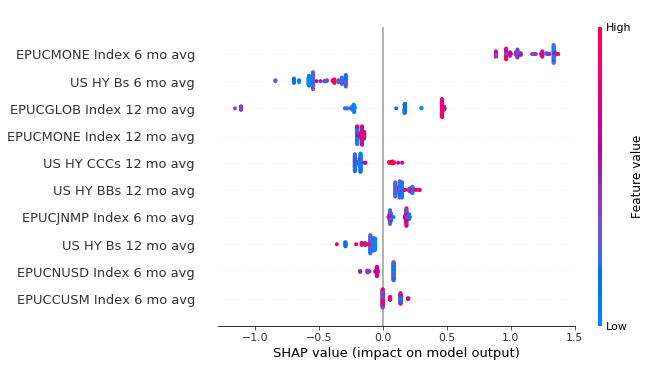

US Mortgages
Model is not compatible for shap plot


In [88]:
for asset_class in merge_3month_Y.columns.values:
    print(asset_class)
    shap_plot(features_classify_3m, model_classify_3m[2], merge_3month_X, asset_class)

# Regression Training

In [64]:
def neg_mse(y_true, y_pred):
    return -mean_squared_error(y_true, y_pred)

def neg_mae(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)

In [68]:
pool_regressor = [
    XGBRegressor(learning_rate=0.03, n_estimators=300, n_jobs=-1, silent=False),
    #XGBRegressor(learning_rate=0.03, n_estimators=500, n_jobs=-1, silent=False),
    XGBRegressor(learning_rate=0.03, n_estimators=1000, n_jobs=-1, silent=False),
    GradientBoostingRegressor(loss='ls',learning_rate=0.05,n_estimators=300),
    #GradientBoostingRegressor(loss='lad',learning_rate=0.05,n_estimators=300),
    GradientBoostingRegressor(loss='ls',learning_rate=0.05,n_estimators=500),
    #GradientBoostingRegressor(loss='lad',learning_rate=0.05,n_estimators=500),
    #GradientBoostingRegressor(loss='ls',learning_rate=0.05,n_estimators=1000),
    GradientBoostingRegressor(loss='ls',learning_rate=0.1,n_estimators=500),
    #GradientBoostingRegressor(loss='lad',learning_rate=0.03,n_estimators=500),
    SVR(kernel='rbf',gamma='auto'),
    SVR(kernel='sigmoid',gamma='auto'),
    RandomForestRegressor(n_estimators=300),
    RandomForestRegressor(n_estimators=500)
]

## One Month Prediction in Regression (This takes a long time to run)

In [66]:
merge_1month_Y_reg = merge_1month[merge_1month.columns[-15:]]

In [69]:
walk_forward_opt(merge_1month_X.iloc[:,:], merge_1month_Y_reg.loc[:,'SPX 500 Price Return'], pool_regressor, 
                      [neg_mse, neg_mae, r2_score], 
                      [False, False, False], ['Neg_MSE','Neg_MAE','R2'])[0]

Neg_MSE   Neg_MAE        R2  \
0  -0.000874 -0.023259 -0.013913   
1  -0.001344 -0.028273 -0.003415   
2  -0.001176 -0.028986 -0.274775   
3  -0.002787 -0.043106 -0.644567   
4  -0.001807 -0.033701 -0.000389   
5  -0.000621 -0.021053 -0.383214   
6  -0.000458 -0.016551 -0.436592   
7  -0.000742 -0.022815  0.203026   
8  -0.004366 -0.052304 -0.042078   
9  -0.000890 -0.023073  0.101477   
10 -0.001031 -0.025195  0.051697   
11 -0.000437 -0.015006 -0.427703   
12 -0.000402 -0.014977  0.193827   
13 -0.000813 -0.021973 -0.104027   
14 -0.000516 -0.017540  0.053698   

                                        Neg_MSE_Model  \
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   XGBRegressor(base_score=0.5, booster='gbtree',...   
10  XGBRegressor(base_score=0.5, booster='gbtree',...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  (DecisionTreeRegressor(criterion='mse', max_de...   
13  (DecisionTreeRegressor(criterion='mse', max_de...   
14  (DecisionTreeRegressor(criterion='mse', max_de...   

                                        Neg_MAE_Model  \
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   (DecisionTreeRegressor(criterion='mse', max_de...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   (DecisionTreeRegressor(criterion='mse', max_de...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   XGBRegressor(base_score=0.5, booster='gbtree',...   
10  XGBRegressor(base_score=0.5, booster='gbtree',...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  (DecisionTreeRegressor(criterion='mse', max_de...   
13  (DecisionTreeRegressor(criterion='mse', max_de...   
14  (DecisionTreeRegressor(criterion='mse', max_de...   

                                             R2_Model  
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...  
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...  
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...  
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...  
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...  
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...  
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...  
7   XGBRegressor(base_score=0.5, booster='gbtree',...  
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...  
9   XGBRegressor(base_score=0.5, booster='gbtree',...  
10  XGBRegressor(base_score=0.5, booster='gbtree',...  
11  (DecisionTreeRegressor(criterion='mse', max_de...  
12  (DecisionTreeRegressor(criterion='mse', max_de...  
13  (DecisionTreeRegressor(criterion='mse', max_de...  
14  (DecisionTreeRegressor(criterion='mse', max_de...

In [70]:
metric_reg_1m, model_reg_1m, features_reg_1m = metric_model_feature_table(
                                 merge_1month_X, merge_1month_Y_reg, pool_regressor, 
                                    [neg_mse, neg_mae, r2_score], [False, False, False], ['Neg_MSE','Neg_MAE','R2'])

### Negative MSE

In [71]:
metric_reg_1m[0]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0   -0.0031               -0.0009        -0.0016     -0.0020     -0.0011   
1   -0.0105               -0.0013        -0.0032     -0.0037     -0.0024   
2   -0.0045               -0.0012        -0.0019     -0.0025     -0.0018   
3   -0.0046               -0.0028        -0.0021     -0.0028     -0.0018   
4   -0.0031               -0.0018        -0.0037     -0.0018     -0.0026   
5   -0.0022               -0.0006        -0.0010     -0.0009     -0.0012   
6   -0.0033               -0.0005        -0.0008     -0.0019     -0.0006   
7   -0.0032               -0.0007        -0.0014     -0.0021     -0.0009   
8   -0.0099               -0.0044        -0.0045     -0.0065     -0.0052   
9   -0.0030               -0.0009        -0.0019     -0.0025     -0.0028   
10  -0.0040               -0.0010        -0.0016     -0.0030     -0.0021   
11  -0.0011               -0.0004        -0.0005     -0.0025     -0.0005   
12  -0.0019               -0.0004        -0.0017     -0.0022     -0.0011   
13  -0.0024               -0.0008        -0.0015     -0.0027     -0.0012   
14  -0.0016               -0.0005        -0.0007     -0.0013     -0.0009   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0        -0.0019                 -0.0068         NaN     -0.0009   
1        -0.0039                 -0.0141         NaN     -0.0011   
2        -0.0042                 -0.0184         NaN     -0.0019   
3        -0.0038                 -0.0104         NaN     -0.0012   
4        -0.0037                 -0.0077         NaN     -0.0018   
5        -0.0019                 -0.0063         NaN     -0.0018   
6        -0.0016                 -0.0057         NaN     -0.0021   
7        -0.0015                 -0.0066         NaN     -0.0021   
8        -0.0071                 -0.0169     -0.0196     -0.0052   
9        -0.0042                 -0.0048     -0.0062     -0.0022   
10       -0.0029                 -0.0059     -0.0077     -0.0037   
11       -0.0013                 -0.0025     -0.0023     -0.0024   
12       -0.0018                 -0.0094     -0.0049     -0.0017   
13       -0.0020                 -0.0077     -0.0086     -0.0022   
14       -0.0019                 -0.0060     -0.0038     -0.0006   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                       -0.0018     -0.0003        -0.0002      -0.0002   
1                       -0.0042     -0.0003        -0.0002      -0.0002   
2                       -0.0049     -0.0002        -0.0002      -0.0001   
3                       -0.0040     -0.0002        -0.0002      -0.0001   
4                       -0.0039     -0.0005        -0.0002      -0.0003   
5                       -0.0031     -0.0004        -0.0002      -0.0003   
6                       -0.0044     -0.0002        -0.0001      -0.0001   
7                       -0.0035     -0.0003        -0.0001      -0.0001   
8                       -0.0100     -0.0007        -0.0003      -0.0008   
9                       -0.0030     -0.0003        -0.0003      -0.0001   
10                      -0.0030     -0.0002        -0.0003      -0.0002   
11                      -0.0013     -0.0003        -0.0002      -0.0002   
12                      -0.0038     -0.0002        -0.0001      -0.0001   
13                      -0.0028     -0.0002        -0.0001      -0.0002   
14                      -0.0017     -0.0001        -0.0001      -0.0001   

    US HY Corp  US Mortgages  
0      -0.0001       -0.0001  
1      -0.0003       -0.0001  
2      -0.0003       -0.0001  
3      -0.0010       -0.0001  
4      -0.0009       -0.0002  
5      -0.0002       -0.0002  
6      -0.0001       -0.0001  
7      -0.0003       -0.0001  
8      -0.0032       -0.0002  
9      -0.0010       -0.0000  
10     -0.0006       -0.0000  
11     -0.0001       -0.0000  
12     -0.0003       -0.0000  
13     -0.0004       -0.0000  
14     -0.0001       -0.0000

In [72]:
model_reg_1m[0]

MSCI EM  \
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   XGBRegressor(base_score=0.5, booster='gbtree',...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                 SPX 500 Price Return  \
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   XGBRegressor(base_score=0.5, booster='gbtree',...   
10  XGBRegressor(base_score=0.5, booster='gbtree',...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  (DecisionTreeRegressor(criterion='mse', max_de...   
13  (DecisionTreeRegressor(criterion='mse', max_de...   
14  (DecisionTreeRegressor(criterion='mse', max_de...   

                                        Eurostoxx 600  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   (DecisionTreeRegressor(criterion='mse', max_de...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI Japan  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   (DecisionTreeRegressor(criterion='mse', max_de...   
5   (DecisionTreeRegressor(criterion='mse', max_de...   
6   (DecisionTreeRegressor(criterion='mse', max_de...   
7   (DecisionTreeRegressor(criterion='mse', max_de...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI World  \
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   (DecisionTreeRegressor(criterion='mse', max_de...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3..

### Negative MAE

In [73]:
metric_reg_1m[1]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0   -0.0366               -0.0233        -0.0289     -0.0364     -0.0244   
1   -0.0767               -0.0283        -0.0391     -0.0449     -0.0394   
2   -0.0510               -0.0284        -0.0354     -0.0412     -0.0355   
3   -0.0547               -0.0431        -0.0394     -0.0397     -0.0349   
4   -0.0465               -0.0337        -0.0498     -0.0363     -0.0416   
5   -0.0380               -0.0211        -0.0264     -0.0250     -0.0286   
6   -0.0461               -0.0168        -0.0228     -0.0332     -0.0193   
7   -0.0428               -0.0228        -0.0282     -0.0352     -0.0225   
8   -0.0790               -0.0523        -0.0541     -0.0637     -0.0579   
9   -0.0433               -0.0231        -0.0340     -0.0392     -0.0420   
10  -0.0469               -0.0252        -0.0325     -0.0420     -0.0345   
11  -0.0265               -0.0149        -0.0187     -0.0396     -0.0169   
12  -0.0373               -0.0146        -0.0320     -0.0364     -0.0256   
13  -0.0372               -0.0222        -0.0323     -0.0405     -0.0266   
14  -0.0313               -0.0174        -0.0218     -0.0250     -0.0210   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0        -0.0342                 -0.0674         NaN     -0.0242   
1        -0.0453                 -0.0884         NaN     -0.0272   
2        -0.0544                 -0.1145         NaN     -0.0249   
3        -0.0546                 -0.0841         NaN     -0.0259   
4        -0.0489                 -0.0711         NaN     -0.0335   
5        -0.0359                 -0.0598         NaN     -0.0338   
6        -0.0320                 -0.0655         NaN     -0.0351   
7        -0.0302                 -0.0700         NaN     -0.0356   
8        -0.0639                 -0.0991     -0.1072     -0.0586   
9        -0.0526                 -0.0513     -0.0634     -0.0383   
10       -0.0397                 -0.0600     -0.0619     -0.0486   
11       -0.0306                 -0.0439     -0.0403     -0.0414   
12       -0.0367                 -0.0725     -0.0619     -0.0328   
13       -0.0338                 -0.0719     -0.0785     -0.0368   
14       -0.0269                 -0.0643     -0.0502     -0.0203   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                       -0.0324     -0.0141        -0.0100      -0.0123   
1                       -0.0521     -0.0129        -0.0103      -0.0106   
2                       -0.0565     -0.0117        -0.0104      -0.0097   
3                       -0.0502     -0.0114        -0.0110      -0.0080   
4                       -0.0488     -0.0181        -0.0126      -0.0130   
5                       -0.0422     -0.0143        -0.0115      -0.0115   
6                       -0.0560     -0.0114        -0.0094      -0.0095   
7                       -0.0517     -0.0136        -0.0095      -0.0093   
8                       -0.0750     -0.0199        -0.0140      -0.0189   
9                       -0.0401     -0.0142        -0.0127      -0.0106   
10                      -0.0434     -0.0130        -0.0150      -0.0122   
11                      -0.0286     -0.0129        -0.0110      -0.0093   
12                      -0.0492     -0.0117        -0.0091      -0.0086   
13                      -0.0400     -0.0093        -0.0098      -0.0090   
14                      -0.0337     -0.0089        -0.0091      -0.0069   

    US HY Corp  US Mortgages  
0      -0.0069       -0.0091  
1      -0.0116       -0.0078  
2      -0.0127       -0.0077  
3      -0.0242       -0.0081  
4      -0.0230       -0.0101  
5      -0.0124       -0.0090  
6      -0.0084       -0.0066  
7      -0.0155       -0.0073  
8      -0.0381       -0.0087  
9      -0.0238       -0.0051  
10     -0.0193       -0.0038  
11     -0.0082       -0.0043  
12     -0.0129       -0.0039  
13     -0.0161       -0.0049  
14     -0.0077       -0.0042

In [74]:
model_reg_1m[1]

MSCI EM  \
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   XGBRegressor(base_score=0.5, booster='gbtree',...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   XGBRegressor(base_score=0.5, booster='gbtree',...   
6   XGBRegressor(base_score=0.5, booster='gbtree',...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   XGBRegressor(base_score=0.5, booster='gbtree',...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                 SPX 500 Price Return  \
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   (DecisionTreeRegressor(criterion='mse', max_de...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   (DecisionTreeRegressor(criterion='mse', max_de...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   XGBRegressor(base_score=0.5, booster='gbtree',...   
10  XGBRegressor(base_score=0.5, booster='gbtree',...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  (DecisionTreeRegressor(criterion='mse', max_de...   
13  (DecisionTreeRegressor(criterion='mse', max_de...   
14  (DecisionTreeRegressor(criterion='mse', max_de...   

                                        Eurostoxx 600  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   (DecisionTreeRegressor(criterion='mse', max_de...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  XGBRegressor(base_score=0.5, booster='gbtree',...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI Japan  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   (DecisionTreeRegressor(criterion='mse', max_de...   
4   (DecisionTreeRegressor(criterion='mse', max_de...   
5   (DecisionTreeRegressor(criterion='mse', max_de...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   (DecisionTreeRegressor(criterion='mse', max_de...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  ([DecisionTreeRegressor(criterion='friedman_ms...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI World  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   XGBRegressor(base_score=0.5, booster='gbtree',...   
5   ([DecisionTreeRegressor(criterion='friedman_ms..

### R Squared

In [75]:
metric_reg_1m[2]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0   -0.0651               -0.0139        -0.0595      0.0033     -0.0445   
1   -0.0206               -0.0034         0.0672     -0.0019     -0.0341   
2   -0.0085               -0.2748        -0.0638     -0.0000     -0.1154   
3    0.0778               -0.6446        -0.0102     -0.3189     -0.0004   
4   -0.0484               -0.0004        -0.0008      0.2110     -0.0934   
5   -0.0823               -0.3832        -0.6042      0.1255     -0.9483   
6   -0.1902               -0.4366        -0.3429     -0.1153     -0.3382   
7    0.0651                0.2030         0.1978      0.0700      0.2079   
8    0.1310               -0.0421        -0.0006     -0.1362      0.0085   
9   -0.1164                0.1015        -0.3596     -0.0002     -0.3213   
10  -0.0044                0.0517        -0.0203     -0.0096     -0.0952   
11  -0.0086               -0.3643        -0.0786     -0.0724      0.1158   
12  -0.0046                0.2404        -0.0901     -0.0319     -0.0540   
13  -0.0135               -0.1237        -0.0335     -0.0001     -0.1257   
14  -0.1117                0.0560        -0.0066     -0.0177     -0.0029   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0        -0.0196                 -0.0325         NaN     -0.0601   
1        -0.0006                  0.0365         NaN     -0.0236   
2         0.0691                 -0.2301         NaN     -0.0044   
3        -0.0023                 -0.0195         NaN     -0.2949   
4        -0.0053                 -0.0273         NaN     -0.1752   
5        -0.0747                 -0.0152         NaN     -0.2071   
6        -0.0373                 -0.0191         NaN      0.0037   
7        -0.0098                  0.0014         NaN     -0.0546   
8         0.0038                  0.0178      0.0348     -0.0000   
9        -0.3162                 -0.0010     -0.0123     -0.0631   
10       -0.0381                 -0.0016     -0.0439     -0.0056   
11       -0.3647                 -0.0731     -0.0054     -0.0506   
12       -0.0208                 -0.0801     -0.1580     -0.0342   
13        0.0163                 -0.0077     -0.0043     -0.0023   
14       -0.0577                 -0.0187     -0.0388     -0.0035   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                        0.0891     -0.1157        -0.2446      -0.1220   
1                        0.0018     -0.0388        -0.1330      -0.1174   
2                       -0.2576     -0.1902        -0.0074      -0.2150   
3                       -0.0284      0.0171        -0.1549      -0.0365   
4                       -0.0035     -0.0029        -0.1903      -0.0172   
5                        0.0035      0.0020        -0.2219       0.0056   
6                        0.0232     -0.1653        -0.0003      -0.1942   
7                        0.0223     -0.1682         0.1558      -0.3781   
8                        0.0102      0.0073        -0.0126       0.1443   
9                       -0.0588     -0.0741        -0.2809       0.0136   
10                      -0.0126     -0.0224        -0.1182      -0.8579   
11                      -0.3404     -0.4630        -0.0660      -0.1478   
12                      -0.0377     -0.2341        -0.1804      -0.1523   
13                      -0.0028      0.0153         0.1019      -0.4574   
14                      -0.0058     -0.0033        -0.1690      -0.0940   

    US HY Corp  US Mortgages  
0       0.0641       -0.0799  
1      -0.1143       -0.0646  
2      -0.2560       -0.1441  
3      -0.0102       -0.0066  
4      -0.1044       -0.0084  
5      -0.2292        0.0049  
6       0.0544       -0.1819  
7      -0.2239       -0.2075  
8       0.0632       -0.1246  
9      -1.4136       -0.1204  
10     -0.3429       -0.3403  
11     -0.2066        0.0057  
12     -0.0760        0.1002  
13     -0.1666       -0.2912  
14     -0.0410       -0.1492

In [76]:
model_reg_1m[2]

MSCI EM  \
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   XGBRegressor(base_score=0.5, booster='gbtree',...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                 SPX 500 Price Return  \
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   XGBRegressor(base_score=0.5, booster='gbtree',...   
10  XGBRegressor(base_score=0.5, booster='gbtree',...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  (DecisionTreeRegressor(criterion='mse', max_de...   
13  (DecisionTreeRegressor(criterion='mse', max_de...   
14  (DecisionTreeRegressor(criterion='mse', max_de...   

                                        Eurostoxx 600  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   (DecisionTreeRegressor(criterion='mse', max_de...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI Japan  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   (DecisionTreeRegressor(criterion='mse', max_de...   
5   (DecisionTreeRegressor(criterion='mse', max_de...   
6   (DecisionTreeRegressor(criterion='mse', max_de...   
7   (DecisionTreeRegressor(criterion='mse', max_de...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI World  \
0   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   (DecisionTreeRegressor(criterion='mse', max_de...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3..

## Shap Plot

### Negative MSE

MSCI EM
Model is not compatible for shap plot
SPX 500 Price Return


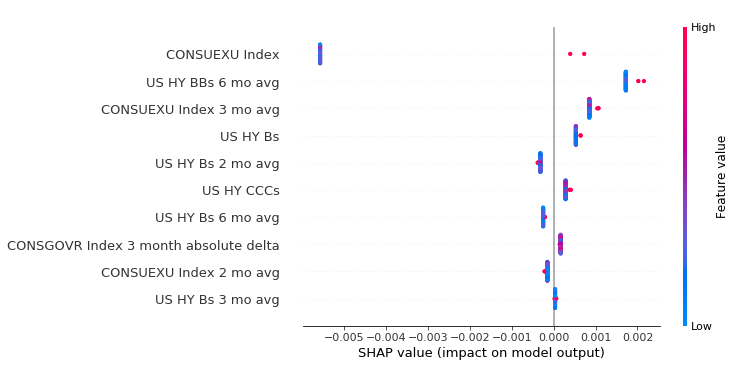

Eurostoxx 600
Model is not compatible for shap plot
MSCI Japan
Model is not compatible for shap plot
MSCI World
Model is not compatible for shap plot
Russell 2000
Model is not compatible for shap plot
Crude Oil Total Return
Model is not compatible for shap plot
CRB Metals
Model is not compatible for shap plot
Gold Price
Model is not compatible for shap plot
S&P GSCI Total Return Index
Model is not compatible for shap plot
UST 7-10yr
Model is not compatible for shap plot
German 7-10yr


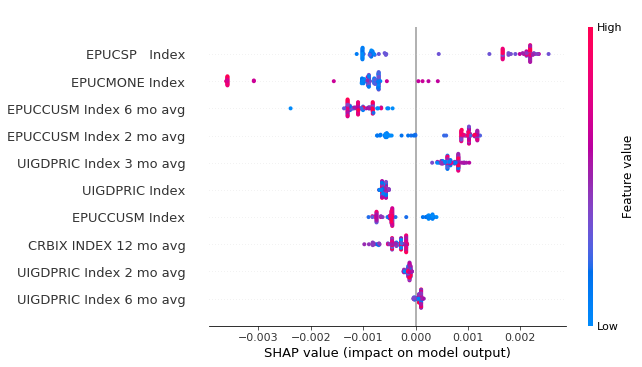

US IG Corps


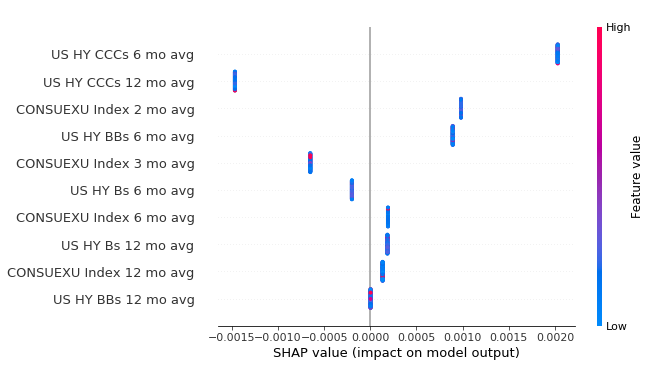

US HY Corp


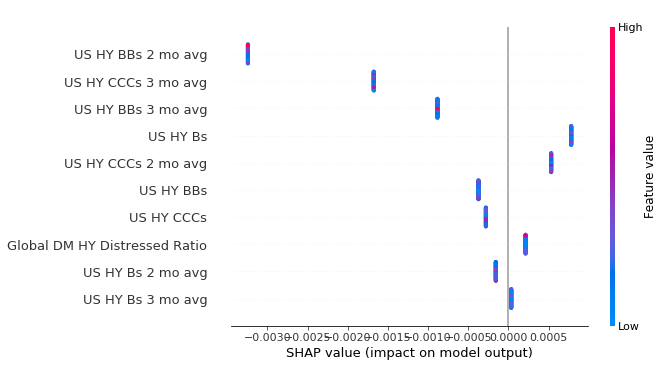

US Mortgages
Model is not compatible for shap plot


In [90]:
for asset_class in merge_1month_Y_reg.columns.values:
    print(asset_class)
    shap_plot(features_reg_1m, model_reg_1m[0], merge_1month_X, asset_class)

### Negative MAE

MSCI EM
Model is not compatible for shap plot
SPX 500 Price Return


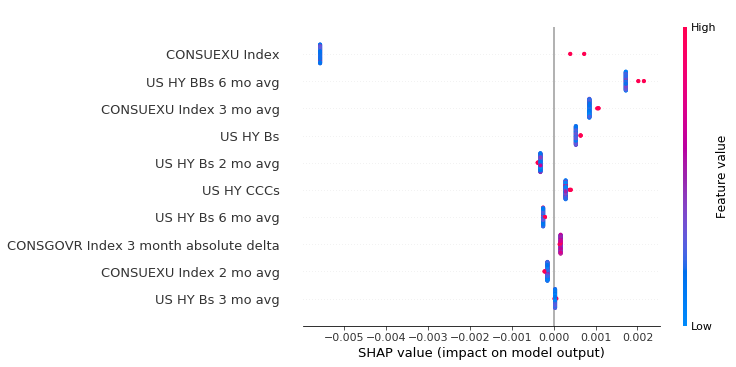

Eurostoxx 600
Model is not compatible for shap plot
MSCI Japan
Model is not compatible for shap plot
MSCI World
Model is not compatible for shap plot
Russell 2000
Model is not compatible for shap plot
Crude Oil Total Return
Model is not compatible for shap plot
CRB Metals


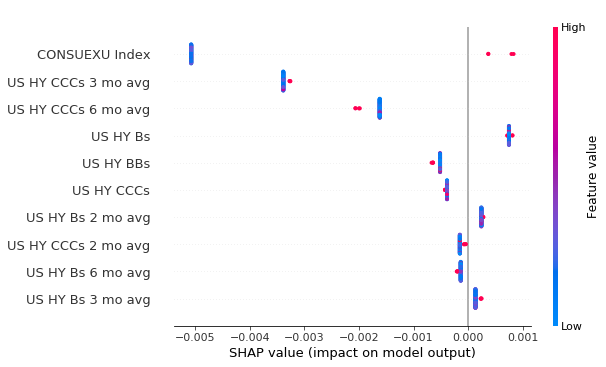

Gold Price
Model is not compatible for shap plot
S&P GSCI Total Return Index
Model is not compatible for shap plot
UST 7-10yr


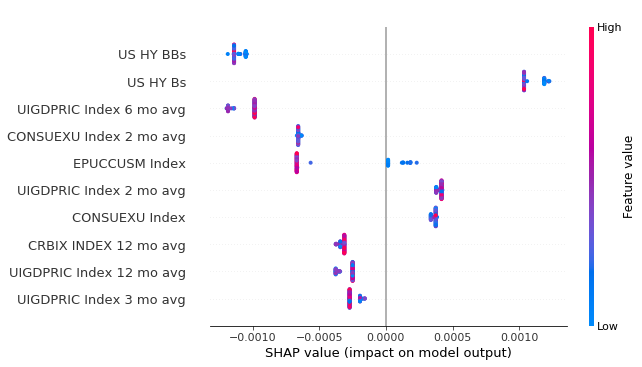

German 7-10yr


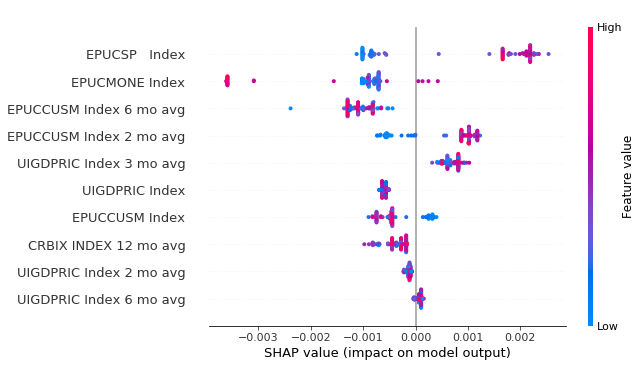

US IG Corps


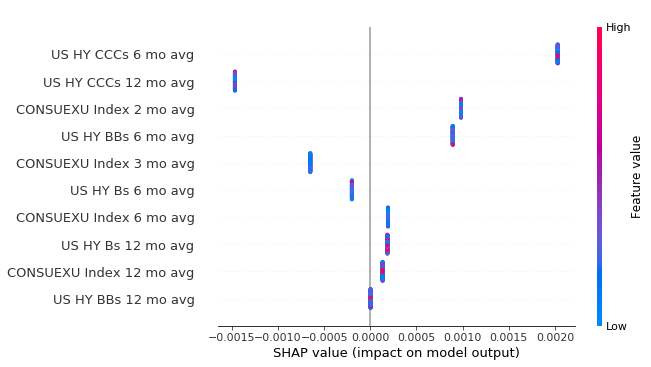

US HY Corp


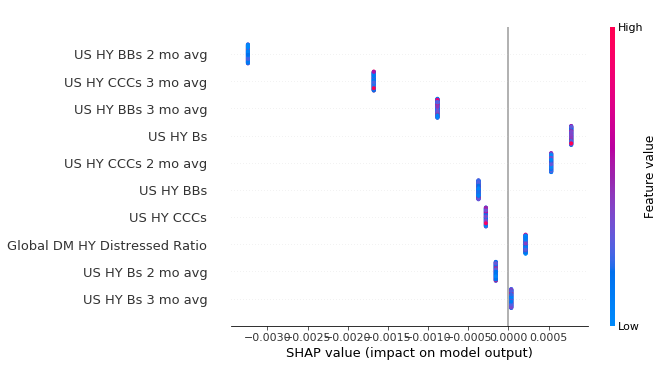

US Mortgages
Model is not compatible for shap plot


In [91]:
for asset_class in merge_1month_Y_reg.columns.values:
    print(asset_class)
    shap_plot(features_reg_1m, model_reg_1m[1], merge_1month_X, asset_class)

### R Squared

MSCI EM
Model is not compatible for shap plot
SPX 500 Price Return


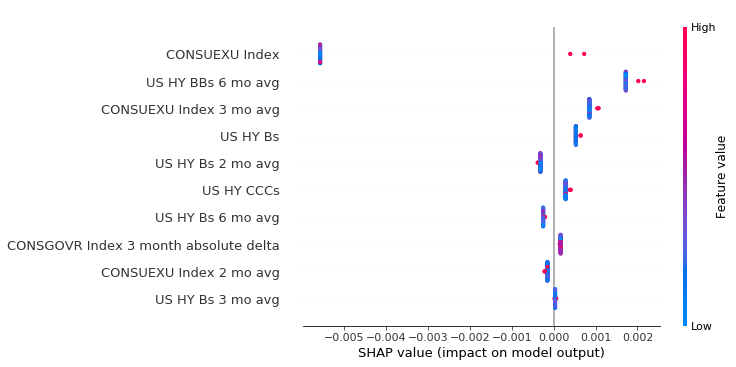

Eurostoxx 600
Model is not compatible for shap plot
MSCI Japan
Model is not compatible for shap plot
MSCI World
Model is not compatible for shap plot
Russell 2000
Model is not compatible for shap plot
Crude Oil Total Return
Model is not compatible for shap plot
CRB Metals
Model is not compatible for shap plot
Gold Price
Model is not compatible for shap plot
S&P GSCI Total Return Index
Model is not compatible for shap plot
UST 7-10yr
Model is not compatible for shap plot
German 7-10yr


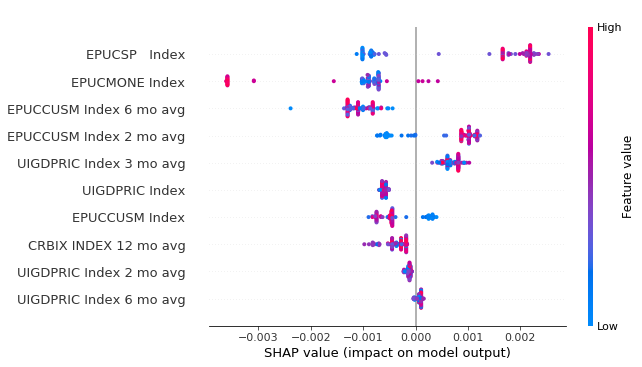

US IG Corps


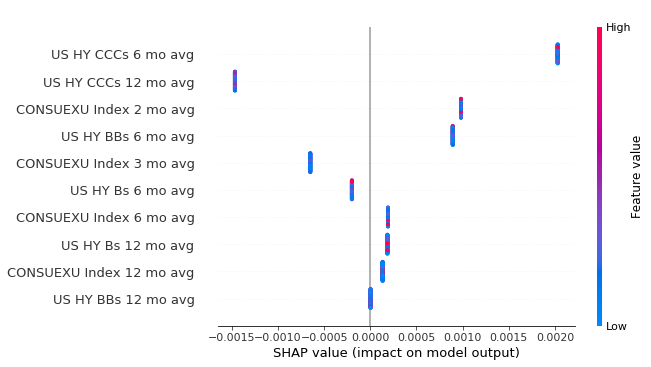

US HY Corp


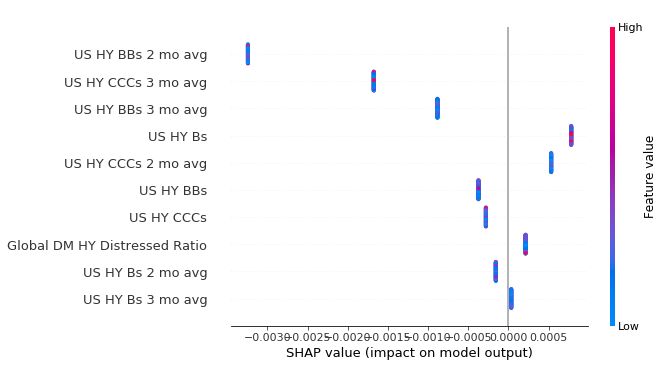

US Mortgages
Model is not compatible for shap plot


In [92]:
for asset_class in merge_1month_Y_reg.columns.values:
    print(asset_class)
    shap_plot(features_reg_1m, model_reg_1m[2], merge_1month_X, asset_class)

## Three Month Prediction in Regression (This takes a long time to run)

In [93]:
merge_3month_Y_reg = merge_3month[merge_3month.columns[-15:]]

In [94]:
metric_reg_3m, model_reg_3m, features_reg_3m = metric_model_feature_table(
                                 merge_3month_X, merge_3month_Y_reg, pool_regressor, 
                                    [neg_mse, neg_mae, r2_score], [False, False, False], ['Neg_MSE','Neg_MAE','R2'])

### Negative MSE

In [95]:
metric_reg_3m[0]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0   -0.0098               -0.0026        -0.0045     -0.0057     -0.0029   
1   -0.0351               -0.0049        -0.0110     -0.0052     -0.0060   
2   -0.0215               -0.0048        -0.0059     -0.0080     -0.0041   
3   -0.0144               -0.0126        -0.0159     -0.0096     -0.0127   
4   -0.0150               -0.0073        -0.0145     -0.0072     -0.0089   
5   -0.0125               -0.0014        -0.0017     -0.0041     -0.0032   
6   -0.0071               -0.0013        -0.0029     -0.0115     -0.0014   
7   -0.0122               -0.0034        -0.0052     -0.0049     -0.0039   
8   -0.0537               -0.0180        -0.0180     -0.0234     -0.0237   
9   -0.0058               -0.0032        -0.0057     -0.0065     -0.0078   
10  -0.0104               -0.0038        -0.0055     -0.0139     -0.0050   
11  -0.0038               -0.0010        -0.0031     -0.0163     -0.0030   
12  -0.0070               -0.0016        -0.0049     -0.0073     -0.0019   
13  -0.0070               -0.0020        -0.0035     -0.0056     -0.0030   
14  -0.0054               -0.0021        -0.0022     -0.0035     -0.0024   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0        -0.0057                 -0.0299         NaN     -0.0037   
1        -0.0111                 -0.0456         NaN     -0.0031   
2        -0.0108                 -0.0516         NaN     -0.0048   
3        -0.0144                 -0.0235         NaN     -0.0021   
4        -0.0158                 -0.0236         NaN     -0.0039   
5        -0.0054                 -0.0173         NaN     -0.0023   
6        -0.0046                 -0.0191         NaN     -0.0060   
7        -0.0044                 -0.0263         NaN     -0.0055   
8        -0.0247                 -0.0844     -0.0998     -0.0111   
9        -0.0106                 -0.0121     -0.0162     -0.0048   
10       -0.0076                 -0.0154     -0.0216     -0.0054   
11       -0.0027                 -0.0052     -0.0079     -0.0128   
12       -0.0035                 -0.0431     -0.0193     -0.0041   
13       -0.0025                 -0.0258     -0.0306     -0.0059   
14       -0.0038                 -0.0206     -0.0109     -0.0021   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                       -0.0082     -0.0008        -0.0003      -0.0006   
1                       -0.0140     -0.0010        -0.0005      -0.0004   
2                       -0.0147     -0.0005        -0.0006      -0.0005   
3                       -0.0104     -0.0012        -0.0007      -0.0005   
4                       -0.0110     -0.0013        -0.0007      -0.0006   
5                       -0.0079     -0.0006        -0.0003      -0.0004   
6                       -0.0134     -0.0005        -0.0004      -0.0003   
7                       -0.0132     -0.0004        -0.0005      -0.0003   
8                       -0.0390     -0.0014        -0.0010      -0.0038   
9                       -0.0081     -0.0013        -0.0006      -0.0011   
10                      -0.0069     -0.0008        -0.0007      -0.0003   
11                      -0.0024     -0.0005        -0.0004      -0.0004   
12                      -0.0173     -0.0005        -0.0004      -0.0003   
13                      -0.0092     -0.0012        -0.0006      -0.0009   
14                      -0.0065     -0.0004        -0.0002      -0.0002   

    US HY Corp  US Mortgages  
0      -0.0003       -0.0004  
1      -0.0012       -0.0003  
2      -0.0029       -0.0004  
3      -0.0026       -0.0007  
4      -0.0036       -0.0005  
5      -0.0008       -0.0002  
6      -0.0007       -0.0001  
7      -0.0010       -0.0003  
8      -0.0157       -0.0004  
9      -0.0028       -0.0001  
10     -0.0011       -0.0001  
11     -0.0003       -0.0001  
12     -0.0007       -0.0001  
13     -0.0023       -0.0001  
14     -0.0007       -0.0001

In [96]:
model_reg_3m[0]

MSCI EM  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   XGBRegressor(base_score=0.5, booster='gbtree',...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   (DecisionTreeRegressor(criterion='mse', max_de...   
4   (DecisionTreeRegressor(criterion='mse', max_de...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                 SPX 500 Price Return  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   ([DecisionTreeRegressor(criterion='friedman_ms...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   ([DecisionTreeRegressor(criterion='friedman_ms...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  XGBRegressor(base_score=0.5, booster='gbtree',...   
14  (DecisionTreeRegressor(criterion='mse', max_de...   

                                        Eurostoxx 600  \
0   XGBRegressor(base_score=0.5, booster='gbtree',...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  (DecisionTreeRegressor(criterion='mse', max_de...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI Japan  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   XGBRegressor(base_score=0.5, booster='gbtree',...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
12  XGBRegressor(base_score=0.5, booster='gbtree',...   
13  ([DecisionTreeRegressor(criterion='friedman_ms...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI World  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   (DecisionTreeRegressor(criterion='mse', max_de...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3..

### Negative MAE

In [97]:
metric_reg_3m[1]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0   -0.0753               -0.0410        -0.0562     -0.0638     -0.0427   
1   -0.1589               -0.0527        -0.0828     -0.0573     -0.0566   
2   -0.1056               -0.0557        -0.0599     -0.0759     -0.0465   
3   -0.0975               -0.0954        -0.1033     -0.0813     -0.1008   
4   -0.0998               -0.0671        -0.0918     -0.0720     -0.0795   
5   -0.0994               -0.0313        -0.0338     -0.0511     -0.0467   
6   -0.0693               -0.0298        -0.0457     -0.0826     -0.0324   
7   -0.0885               -0.0488        -0.0598     -0.0556     -0.0520   
8   -0.1753               -0.1100        -0.1157     -0.1195     -0.1260   
9   -0.0615               -0.0418        -0.0537     -0.0679     -0.0748   
10  -0.0751               -0.0519        -0.0615     -0.0943     -0.0592   
11  -0.0547               -0.0243        -0.0451     -0.0992     -0.0461   
12  -0.0654               -0.0283        -0.0562     -0.0762     -0.0351   
13  -0.0706               -0.0370        -0.0483     -0.0612     -0.0487   
14  -0.0638               -0.0340        -0.0355     -0.0452     -0.0346   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0        -0.0598                 -0.1454         NaN     -0.0515   
1        -0.0870                 -0.1815         NaN     -0.0463   
2        -0.0820                 -0.1831         NaN     -0.0463   
3        -0.0905                 -0.1179         NaN     -0.0382   
4        -0.0996                 -0.1231         NaN     -0.0523   
5        -0.0656                 -0.1160         NaN     -0.0396   
6        -0.0557                 -0.1146         NaN     -0.0628   
7        -0.0533                 -0.1387         NaN     -0.0564   
8        -0.1196                 -0.2247     -0.2414     -0.0816   
9        -0.0875                 -0.0930     -0.1087     -0.0550   
10       -0.0679                 -0.1053     -0.1079     -0.0610   
11       -0.0401                 -0.0586     -0.0720     -0.0895   
12       -0.0446                 -0.1749     -0.1154     -0.0533   
13       -0.0378                 -0.1293     -0.1417     -0.0635   
14       -0.0449                 -0.1198     -0.0897     -0.0381   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                       -0.0750     -0.0210        -0.0142      -0.0183   
1                       -0.1077     -0.0260        -0.0170      -0.0170   
2                       -0.1085     -0.0200        -0.0194      -0.0178   
3                       -0.0849     -0.0287        -0.0229      -0.0175   
4                       -0.0791     -0.0275        -0.0212      -0.0194   
5                       -0.0721     -0.0212        -0.0142      -0.0154   
6                       -0.0906     -0.0204        -0.0167      -0.0147   
7                       -0.0929     -0.0176        -0.0194      -0.0147   
8                       -0.1511     -0.0267        -0.0236      -0.0467   
9                       -0.0778     -0.0294        -0.0195      -0.0263   
10                      -0.0698     -0.0241        -0.0208      -0.0151   
11                      -0.0400     -0.0157        -0.0160      -0.0130   
12                      -0.1123     -0.0175        -0.0140      -0.0122   
13                      -0.0828     -0.0252        -0.0198      -0.0249   
14                      -0.0644     -0.0167        -0.0114      -0.0119   

    US HY Corp  US Mortgages  
0      -0.0134       -0.0153  
1      -0.0231       -0.0162  
2      -0.0470       -0.0173  
3      -0.0409       -0.0224  
4      -0.0501       -0.0177  
5      -0.0238       -0.0120  
6      -0.0226       -0.0099  
7      -0.0276       -0.0143  
8      -0.0892       -0.0130  
9      -0.0421       -0.0090  
10     -0.0252       -0.0067  
11     -0.0094       -0.0075  
12     -0.0222       -0.0078  
13     -0.0415       -0.0082  
14     -0.0199       -0.0065

In [98]:
model_reg_3m[1]

MSCI EM  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   (DecisionTreeRegressor(criterion='mse', max_de...   
2   ([DecisionTreeRegressor(criterion='friedman_ms...   
3   (DecisionTreeRegressor(criterion='mse', max_de...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                 SPX 500 Price Return  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   ([DecisionTreeRegressor(criterion='friedman_ms...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   ([DecisionTreeRegressor(criterion='friedman_ms...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  (DecisionTreeRegressor(criterion='mse', max_de...   
13  XGBRegressor(base_score=0.5, booster='gbtree',...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                        Eurostoxx 600  \
0   XGBRegressor(base_score=0.5, booster='gbtree',...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   (DecisionTreeRegressor(criterion='mse', max_de...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   (DecisionTreeRegressor(criterion='mse', max_de...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  (DecisionTreeRegressor(criterion='mse', max_de...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI Japan  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   XGBRegressor(base_score=0.5, booster='gbtree',...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
12  XGBRegressor(base_score=0.5, booster='gbtree',...   
13  ([DecisionTreeRegressor(criterion='friedman_ms...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI World  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3..

### R Squared

In [99]:
metric_reg_3m[2]

MSCI EM  SPX 500 Price Return  Eurostoxx 600  MSCI Japan  MSCI World  \
0   -0.1626               -0.0375        -0.0647      0.0851     -0.0137   
1   -0.0368               -0.0113        -0.0036      0.5372      0.0686   
2   -0.0153               -0.8472        -0.0001     -0.0265     -0.2846   
3    0.1519               -1.6454        -1.3363     -0.3971     -2.4428   
4   -0.1194                0.1093        -0.1702      0.3086     -0.0014   
5   -0.5831               -0.0064        -0.2258     -0.3316     -0.2930   
6    0.0463               -0.1437        -0.7999     -0.5113     -0.0526   
7   -0.0058               -0.0096         0.1088      0.1985      0.1015   
8   -0.0045               -0.0003        -0.0012     -0.1249     -0.0044   
9   -0.0000                0.2594        -0.4681     -0.0181     -0.4308   
10  -0.1506               -0.0417        -0.0363     -0.0020     -0.0040   
11  -0.0007               -0.2492        -2.1898     -0.6015     -2.5507   
12  -0.1911               -0.0414        -0.0565     -0.0218     -0.0220   
13  -0.1158                0.0047        -0.0385      0.1757     -0.3061   
14  -0.0169                0.0179        -0.0915     -0.0264     -0.0001   

    Russell 2000  Crude Oil Total Return  CRB Metals  Gold Price  \
0        -0.0006                 -0.0196         NaN     -2.3984   
1         0.1211                 -0.0217         NaN     -0.5698   
2        -0.0048                 -1.1928         NaN     -0.0846   
3        -0.2219                 -0.0172         NaN      0.1066   
4        -0.0000                 -0.1251         NaN     -0.3650   
5        -0.0595                 -0.0734         NaN      0.0347   
6         0.0014                 -0.2072         NaN     -0.1802   
7        -0.0841                 -0.0004         NaN      0.2589   
8        -0.0071                 -0.0214     -0.0096     -0.0503   
9        -0.1388                 -0.0336     -0.0167     -0.0664   
10       -0.0003                 -0.0074     -0.4798     -0.0130   
11       -0.4022                 -0.0001     -0.0000     -1.1009   
12       -0.0154                 -0.4503     -0.8234     -0.0450   
13        0.5013                 -0.0135     -0.0569     -0.0011   
14        0.1605                 -0.0371      0.0279     -0.0011   

    S&P GSCI Total Return Index  UST 7-10yr  German 7-10yr  US IG Corps  \
0                       -0.0280      0.1212        -0.0447       0.0134   
1                       -0.1080     -0.1026         0.2931      -0.1013   
2                       -2.3833      0.2776        -0.0055      -0.0281   
3                       -0.0400     -0.4101        -0.3386      -0.5504   
4                       -0.2579     -0.2362        -0.5024      -0.2351   
5                        0.0494     -0.0544         0.0234       0.0064   
6                       -0.0056     -0.2219        -0.0300      -0.0123   
7                       -0.0035      0.4345        -0.0357      -0.0037   
8                        0.1961      0.0829        -0.0092       0.0008   
9                       -0.1067     -0.0621         0.3438      -1.3432   
10                      -0.0014     -0.0351        -0.0134      -0.8716   
11                      -0.0284     -0.1064        -0.0995       0.1286   
12                      -0.4637     -0.5459        -0.1135      -0.1785   
13                       0.1033     -0.7376        -0.8639      -0.8144   
14                      -0.0159     -0.3998        -0.0917       0.1496   

    US HY Corp  US Mortgages  
0      -0.0837        0.0342  
1      -0.4720       -0.3629  
2      -1.6169       -0.1104  
3      -0.0506       -0.8820  
4      -0.1175       -0.3933  
5      -0.1626       -0.0005  
6      -0.4714       -0.0060  
7      -0.0469       -0.1590  
8       0.0055       -0.0473  
9      -1.2795       -0.1388  
10     -0.2111       -0.3473  
11     -0.0321       -0.5112  
12     -0.0085       -0.9229  
13     -0.5063        0.0529  
14     -1.1948       -0.0338

In [100]:
model_reg_3m[2]

MSCI EM  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   XGBRegressor(base_score=0.5, booster='gbtree',...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   (DecisionTreeRegressor(criterion='mse', max_de...   
4   (DecisionTreeRegressor(criterion='mse', max_de...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   ([DecisionTreeRegressor(criterion='friedman_ms...   
7   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                 SPX 500 Price Return  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   ([DecisionTreeRegressor(criterion='friedman_ms...   
4   ([DecisionTreeRegressor(criterion='friedman_ms...   
5   ([DecisionTreeRegressor(criterion='friedman_ms...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   ([DecisionTreeRegressor(criterion='friedman_ms...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
13  XGBRegressor(base_score=0.5, booster='gbtree',...   
14  (DecisionTreeRegressor(criterion='mse', max_de...   

                                        Eurostoxx 600  \
0   XGBRegressor(base_score=0.5, booster='gbtree',...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   XGBRegressor(base_score=0.5, booster='gbtree',...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  (DecisionTreeRegressor(criterion='mse', max_de...   
12  (DecisionTreeRegressor(criterion='mse', max_de...   
13  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI Japan  \
0   ([DecisionTreeRegressor(criterion='friedman_ms...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
4   XGBRegressor(base_score=0.5, booster='gbtree',...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
6   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
7   ([DecisionTreeRegressor(criterion='friedman_ms...   
8   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
9   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
10  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
11  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
12  XGBRegressor(base_score=0.5, booster='gbtree',...   
13  ([DecisionTreeRegressor(criterion='friedman_ms...   
14  SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   

                                           MSCI World  \
0   (DecisionTreeRegressor(criterion='mse', max_de...   
1   ([DecisionTreeRegressor(criterion='friedman_ms...   
2   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
3   (DecisionTreeRegressor(criterion='mse', max_de...   
4   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3...   
5   SVR(C=1.0, cache_size=200, coef0=0.0, degree=3..

## Shap Plot

### Negative MSE

MSCI EM
Model is not compatible for shap plot
SPX 500 Price Return


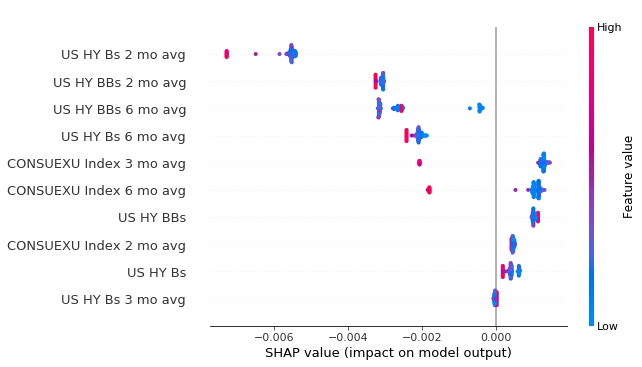

Eurostoxx 600
Model is not compatible for shap plot
MSCI Japan
Model is not compatible for shap plot
MSCI World
Model is not compatible for shap plot
Russell 2000
Model is not compatible for shap plot
Crude Oil Total Return
Model is not compatible for shap plot
CRB Metals
Model is not compatible for shap plot
Gold Price
Model is not compatible for shap plot
S&P GSCI Total Return Index
Model is not compatible for shap plot
UST 7-10yr


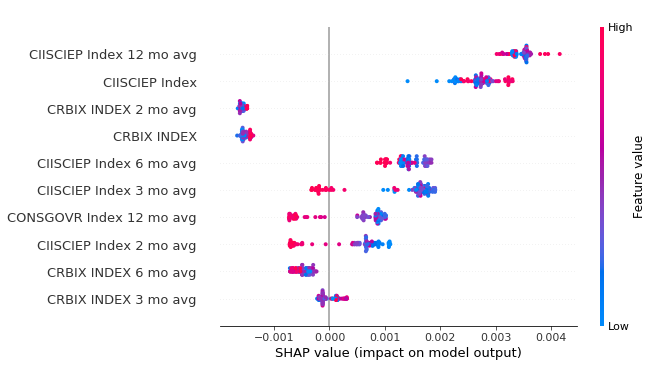

German 7-10yr


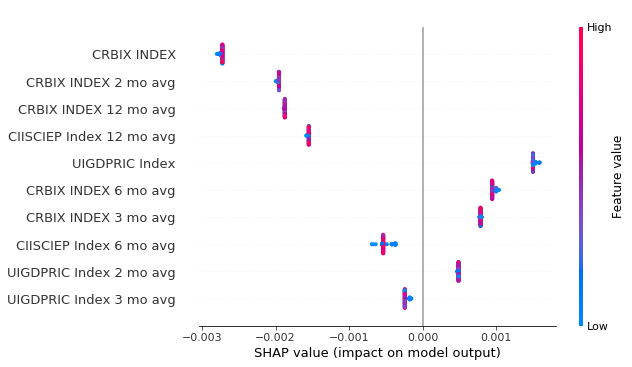

US IG Corps


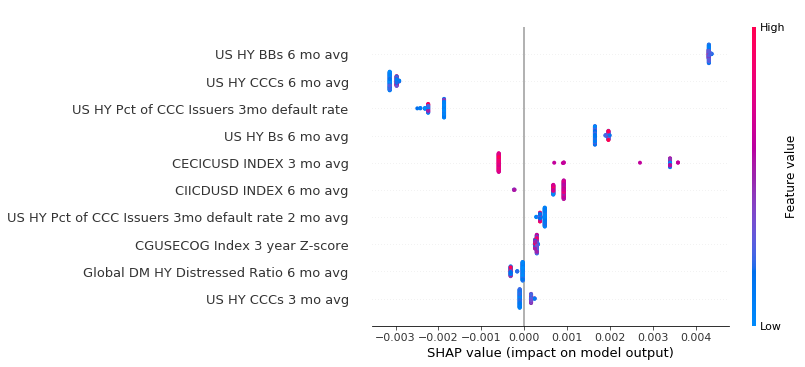

US HY Corp


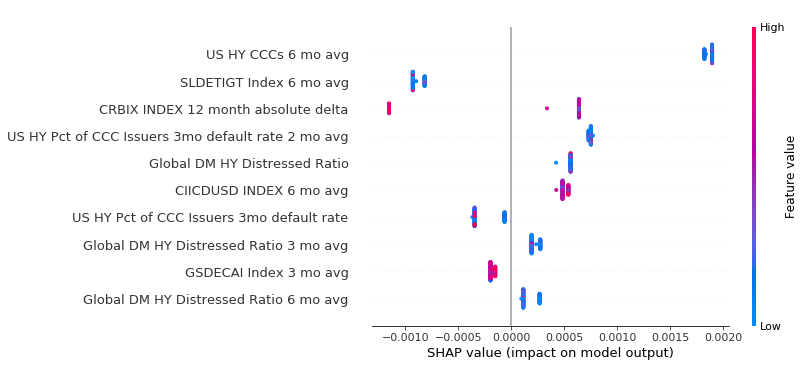

US Mortgages
Model is not compatible for shap plot


In [101]:
for asset_class in merge_3month_Y_reg.columns.values:
    print(asset_class)
    shap_plot(features_reg_3m, model_reg_3m[0], merge_3month_X, asset_class)

### Negative MAE

MSCI EM
Model is not compatible for shap plot
SPX 500 Price Return
Model is not compatible for shap plot
Eurostoxx 600
Model is not compatible for shap plot
MSCI Japan
Model is not compatible for shap plot
MSCI World
Model is not compatible for shap plot
Russell 2000
Model is not compatible for shap plot
Crude Oil Total Return
Model is not compatible for shap plot
CRB Metals


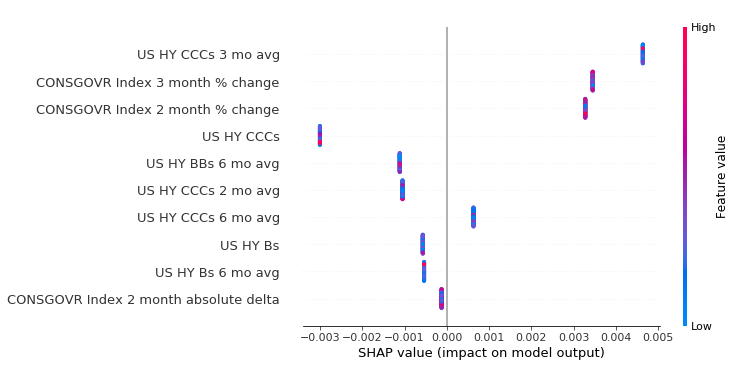

Gold Price
Model is not compatible for shap plot
S&P GSCI Total Return Index
Model is not compatible for shap plot
UST 7-10yr


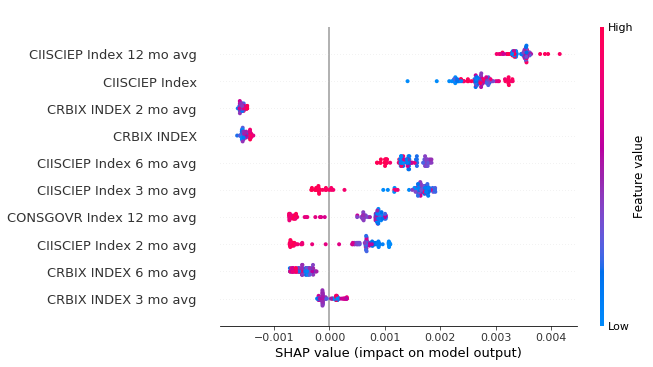

German 7-10yr


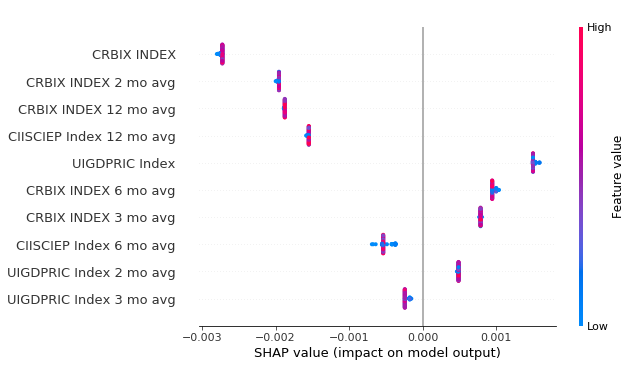

US IG Corps
Model is not compatible for shap plot
US HY Corp


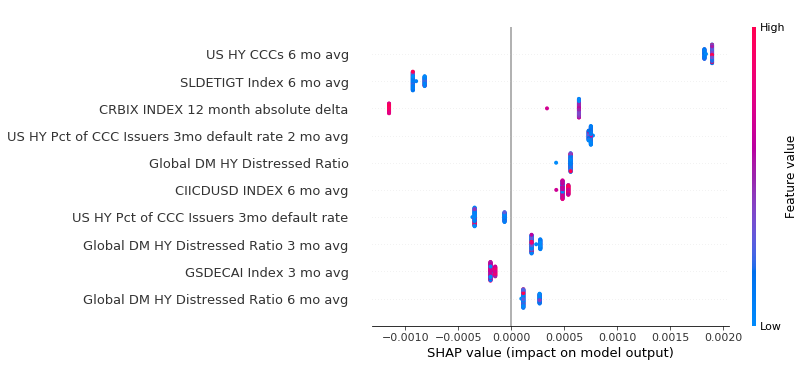

US Mortgages
Model is not compatible for shap plot


In [102]:
for asset_class in merge_3month_Y_reg.columns.values:
    print(asset_class)
    shap_plot(features_reg_3m, model_reg_3m[1], merge_3month_X, asset_class)

### R Squared

MSCI EM
Model is not compatible for shap plot
SPX 500 Price Return


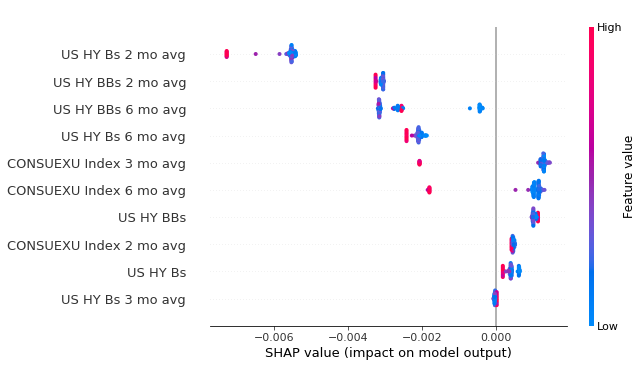

Eurostoxx 600
Model is not compatible for shap plot
MSCI Japan
Model is not compatible for shap plot
MSCI World
Model is not compatible for shap plot
Russell 2000
Model is not compatible for shap plot
Crude Oil Total Return
Model is not compatible for shap plot
CRB Metals
Model is not compatible for shap plot
Gold Price
Model is not compatible for shap plot
S&P GSCI Total Return Index
Model is not compatible for shap plot
UST 7-10yr


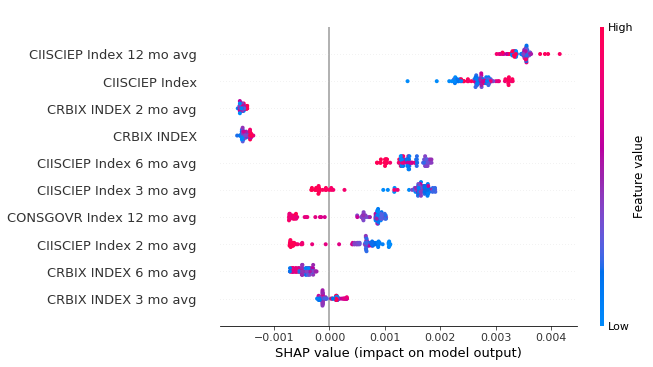

German 7-10yr


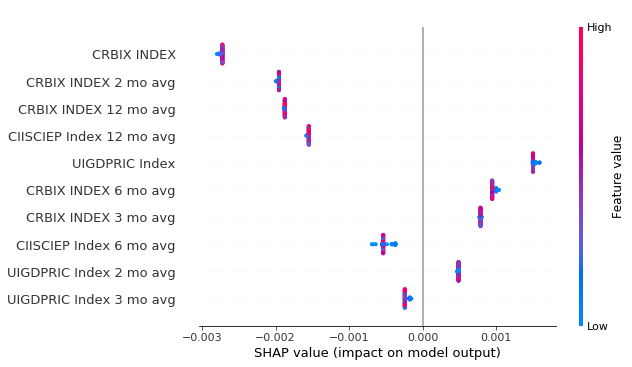

US IG Corps


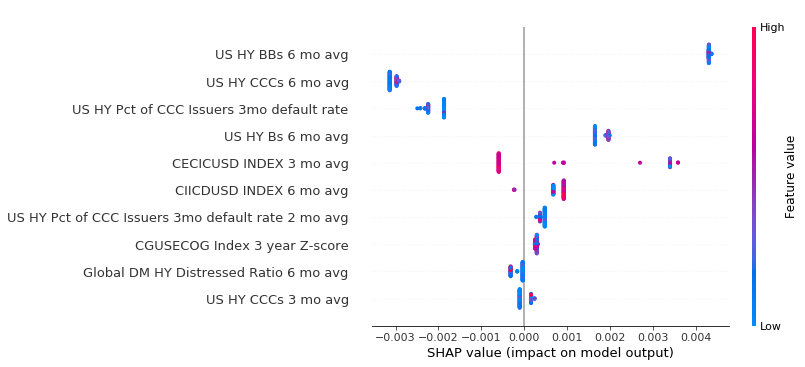

US HY Corp


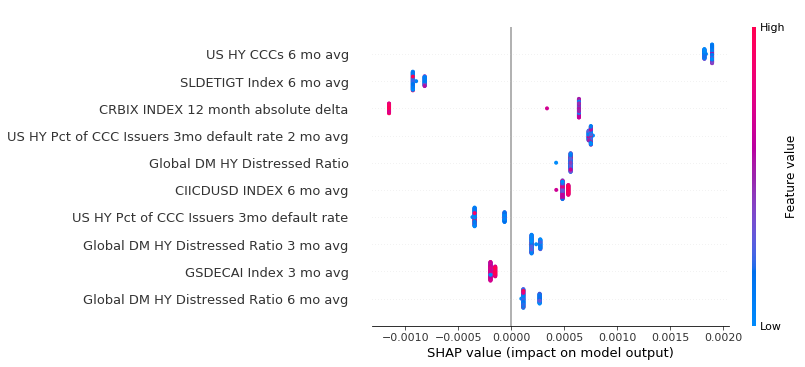

US Mortgages
Model is not compatible for shap plot


In [103]:
for asset_class in merge_3month_Y_reg.columns.values:
    print(asset_class)
    shap_plot(features_reg_3m, model_reg_3m[2], merge_3month_X, asset_class)